In [18]:
#ARIMA

In [2]:
import os
# --------- CONFIG --------------------------------
mainpath="/Users/DELL/datasets"
filename="VEN.csv"
FILE=os.path.join(mainpath,filename)

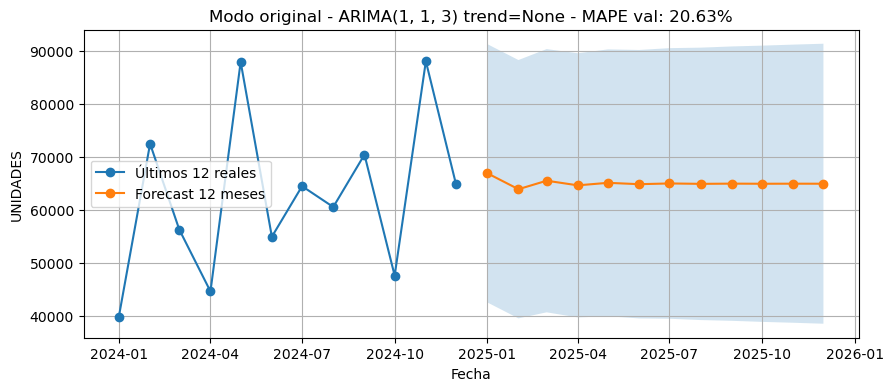

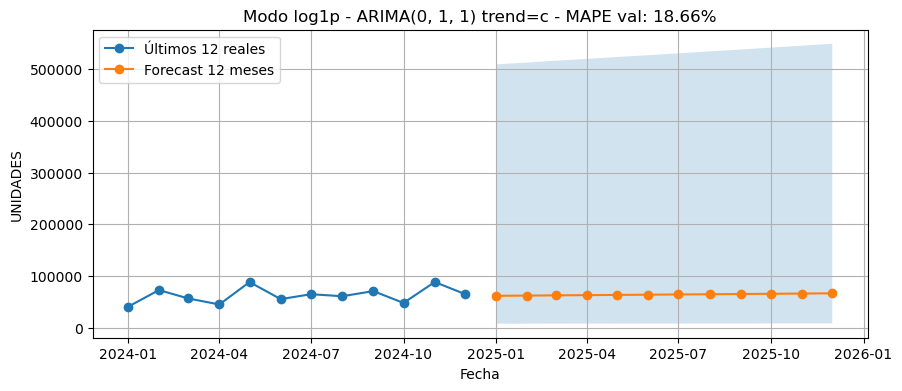


📊 COMPARATIVO DE RESULTADOS ENTRE SERIES (Original vs Log1p)
         ARIMA (p,d,q) Tendencia       MAE      RMSE MAPE (%)      R²  \
original     (1, 1, 3)      None  12063.07  14833.16    20.63 -0.0051   
log1p        (0, 1, 1)         c  11882.56  15110.55    18.66 -0.0431   

         Ljung-Box (p) Shapiro-Wilk (p) Jarque-Bera (p)  
original        0.1484           0.0002             0.0  
log1p           0.9904              0.0             0.0  

Interpretación:
- MAPE, MAE y RMSE indican la precisión del modelo (menor es mejor).
- R² mide el ajuste general (más cercano a 1 es mejor).
- Pruebas Ljung–Box, Shapiro y Jarque–Bera evalúan los residuos:
   • Ljung–Box p>0.05 → residuos sin autocorrelación (deseable).
   • Shapiro p>0.05 y Jarque–Bera p>0.05 → residuos normales (deseable).


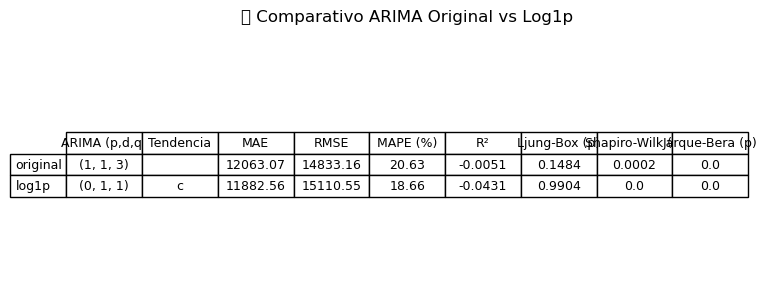

In [3]:
# ARIMA automático (d=1) con tendencia/constante (busca trend entre 't','c',None)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings, pickle
warnings.filterwarnings("ignore")

def safe_mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

df = pd.read_csv(FILE)
df['FECHA'] = pd.to_datetime(df['AÑO'].astype(str) + '-' + df['MES'].astype(str) + '-01', errors='coerce')
df['UNIDADES'] = pd.to_numeric(df['UNIDADES'], errors='coerce')
ts = df.groupby(pd.Grouper(key='FECHA', freq='MS'))['UNIDADES'].sum()
ts = ts.reindex(pd.date_range(ts.index.min(), ts.index.max(), freq='MS')).astype(float)

# validación: últimos 12 meses si hay >=24 puntos, sino 20%
n = ts.dropna().shape[0]
test_periods = 12 if n >= 24 else max(1, int(np.ceil(0.2 * n)))

results = {}

for mode in ['original','log1p']:
    series = ts.copy() if mode=='original' else np.log1p(ts)
    if series.isna().any():
        series = series.interpolate().ffill().bfill()
    train = series.iloc[:-test_periods]
    val = series.iloc[-test_periods:]
    best = None
    best_info = None
    # buscar p,q en 0..4 con d=0, probar trend en 't','c',None
    for trend in ['t','c', None]:
        for p in range(0,5):
            for q in range(0,5):
                try:
                    mod = SARIMAX(train, order=(p,1,q), trend=trend,
                                  enforce_stationarity=False, enforce_invertibility=False)
                    res = mod.fit(disp=False, maxiter=50)
                    pred = res.get_forecast(steps=len(val)).predicted_mean
                    if mode=='log1p':
                        pred_bt = np.expm1(pred); val_bt = np.expm1(val); hist = np.expm1(train)
                    else:
                        pred_bt = pred; val_bt = val; hist = train
                    mape = safe_mape(val_bt.values, pred_bt.values)
                    hist_std = np.nanstd(hist.values)
                    pred_std = np.nanstd(pred_bt.values)
                    pred_range = pred_bt.max() - pred_bt.min()
                    not_flat = (pred_std > 0.005 * max(1.0, hist_std)) and (pred_range > 0.005 * max(1.0, np.nanmean(val_bt)))
                    hist_max = np.nanmax(np.abs(hist.values))
                    if np.any(np.abs(pred_bt) > 50 * max(1, hist_max)):
                        continue
                    score = np.inf if mape is None or np.isnan(mape) else mape
                    if not not_flat:
                        score += 100.0
                    if best is None or score < best:
                        best = score
                        best_info = {'order':(p,1,q),'trend':trend,'res':res,'mape_val':mape,'not_flat':not_flat}
                except Exception:
                    continue
    if best_info is None:
        raise RuntimeError("No se encontró modelo ARIMA válido con d=0")
    order = best_info['order']; trend = best_info['trend']
    # Reajustar sobre la serie completa y predecir 12 meses futuros
    full_series = series.copy()
    model_full = SARIMAX(full_series, order=(order[0],1,order[2]), trend=trend,
                         enforce_stationarity=False, enforce_invertibility=False)
    res_full = model_full.fit(disp=False, maxiter=200)
    pred_full_obj = res_full.get_forecast(steps=12)
    pred_full = pd.Series(pred_full_obj.predicted_mean.values, index=pd.date_range(full_series.index.max()+pd.offsets.MonthBegin(1), periods=12, freq='MS'))
    pred_full_ci = pred_full_obj.conf_int()
    if mode=='log1p':
        forecast_bt = pd.Series(np.expm1(pred_full.values), index=pred_full.index)
        ci_lower = np.expm1(pred_full_ci.iloc[:,0].values)
        ci_upper = np.expm1(pred_full_ci.iloc[:,1].values)
        hist_to_plot = np.expm1(full_series)
    else:
        forecast_bt = pred_full.astype(float)
        ci_lower = pred_full_ci.iloc[:,0].astype(float).values
        ci_upper = pred_full_ci.iloc[:,1].astype(float).values
        hist_to_plot = full_series
    # metrics on validation
    res_val = best_info['res']
    pred_val = pd.Series(res_val.get_forecast(steps=len(val)).predicted_mean.values, index=val.index)
    if mode=='log1p':
        pred_val_bt = pd.Series(np.expm1(pred_val.values), index=val.index)
        val_bt = pd.Series(np.expm1(val.values), index=val.index)
    else:
        pred_val_bt = pred_val; val_bt = val
    mae = mean_absolute_error(val_bt.values, pred_val_bt.values)
    rmse = np.sqrt(mean_squared_error(val_bt.values, pred_val_bt.values))
    mape = safe_mape(val_bt.values, pred_val_bt.values)
    r2 = r2_score(val_bt.values, pred_val_bt.values) if len(val_bt)>1 else np.nan
    resid = res_full.resid.dropna()
    lb_p = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0] if len(resid)>10 else np.nan
    sw_p = shapiro(resid)[1] if len(resid)>3 else np.nan
    jb_p = jarque_bera(resid)[1] if len(resid)>8 else np.nan
    results[mode] = {
        'selected_order': order, 'selected_trend': trend, 'val_mape': mape, 'val_mae': mae, 'val_rmse': rmse, 'val_r2': r2,
        'ljung_p': lb_p, 'shapiro_p': sw_p, 'jarque_p': jb_p,
        'forecast_12_future': forecast_bt, 'ci_lower': ci_lower, 'ci_upper': ci_upper,
        'res_full': res_full, 'res_val': res_val, 'pred_val_bt': pred_val_bt, 'val_series': val_bt,
        'hist_to_plot': hist_to_plot
    }

    # plot last 12 real and next 12 forecast
    last12 = hist_to_plot.index[-12:]
    plt.figure(figsize=(10,4))
    plt.plot(last12, hist_to_plot.loc[last12].values, marker='o', label='Últimos 12 reales')
    plt.plot(results[mode]['forecast_12_future'].index, results[mode]['forecast_12_future'].values, marker='o', label='Forecast 12 meses')
    plt.fill_between(results[mode]['forecast_12_future'].index, results[mode]['ci_lower'], results[mode]['ci_upper'], alpha=0.2)
    plt.title(f"Modo {mode} - ARIMA{order} trend={trend} - MAPE val: {mape:.2f}%")
    plt.xlabel("Fecha"); plt.ylabel("UNIDADES")
    plt.legend(); plt.grid(True); plt.show()

# Guardar resultados
with open('arima_d0_trend_results.pkl','wb') as f:
    pickle.dump(results, f)

# ============================================
# 🔚 COMPARACIÓN FINAL ENTRE MODOS
# ============================================
import pandas as pd

# Crear tabla comparativa con métricas clave
summary = pd.DataFrame({
    mode: {
        'ARIMA (p,d,q)': results[mode]['selected_order'],
        'Tendencia': results[mode]['selected_trend'],
        'MAE': round(results[mode]['val_mae'], 2),
        'RMSE': round(results[mode]['val_rmse'], 2),
        'MAPE (%)': round(results[mode]['val_mape'], 2),
        'R²': round(results[mode]['val_r2'], 4) if not np.isnan(results[mode]['val_r2']) else np.nan,
        'Ljung-Box (p)': round(results[mode]['ljung_p'], 4),
        'Shapiro-Wilk (p)': round(results[mode]['shapiro_p'], 4),
        'Jarque-Bera (p)': round(results[mode]['jarque_p'], 4)
    }
    for mode in results
}).T

print("\n" + "="*80)
print("📊 COMPARATIVO DE RESULTADOS ENTRE SERIES (Original vs Log1p)")
print("="*80)
print(summary)
print("\nInterpretación:")
print("- MAPE, MAE y RMSE indican la precisión del modelo (menor es mejor).")
print("- R² mide el ajuste general (más cercano a 1 es mejor).")
print("- Pruebas Ljung–Box, Shapiro y Jarque–Bera evalúan los residuos:")
print("   • Ljung–Box p>0.05 → residuos sin autocorrelación (deseable).")
print("   • Shapiro p>0.05 y Jarque–Bera p>0.05 → residuos normales (deseable).")
print("="*80)

# Si deseas, también puedes visualizarlo bonito con matplotlib
plt.figure(figsize=(8, 3))
plt.axis('off')
table = plt.table(cellText=summary.values,
                  rowLabels=summary.index,
                  colLabels=summary.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.1, 1.3)
plt.title("📊 Comparativo ARIMA Original vs Log1p", fontsize=12, pad=20)
plt.show()




📊 ANÁLISIS BOX–JENKINS COMPARATIVO
Observaciones: 204 | Media: 37,517.21 | Std: 18,358.03

🔍 Analizando serie ORIGINAL...
Diferenciación detectada: d = 1

--- Serie Original ---
Modelo: ARIMA(1, 1, 2)
AIC: 4409.50 | BIC: 4422.75
MAE: 8903.51 | RMSE: 12326.40 | MAPE: 27.56%

🔍 Analizando serie LOGARÍTMICA...
Diferenciación detectada: d = 0

--- Serie Logarítmica (ln(1+x)) ---
Modelo: ARIMA(1, 0, 1)
AIC: 622.82 | BIC: 636.09
MAE: 0.42 | RMSE: 1.09 | MAPE: 3.13%

----------------------------------------------------------------------
🔮 Pronóstico comparativo a 12 períodos
----------------------------------------------------------------------
Original - Media pronóstico: 64,992.80
Log→exp - Media pronóstico: 51,465.92


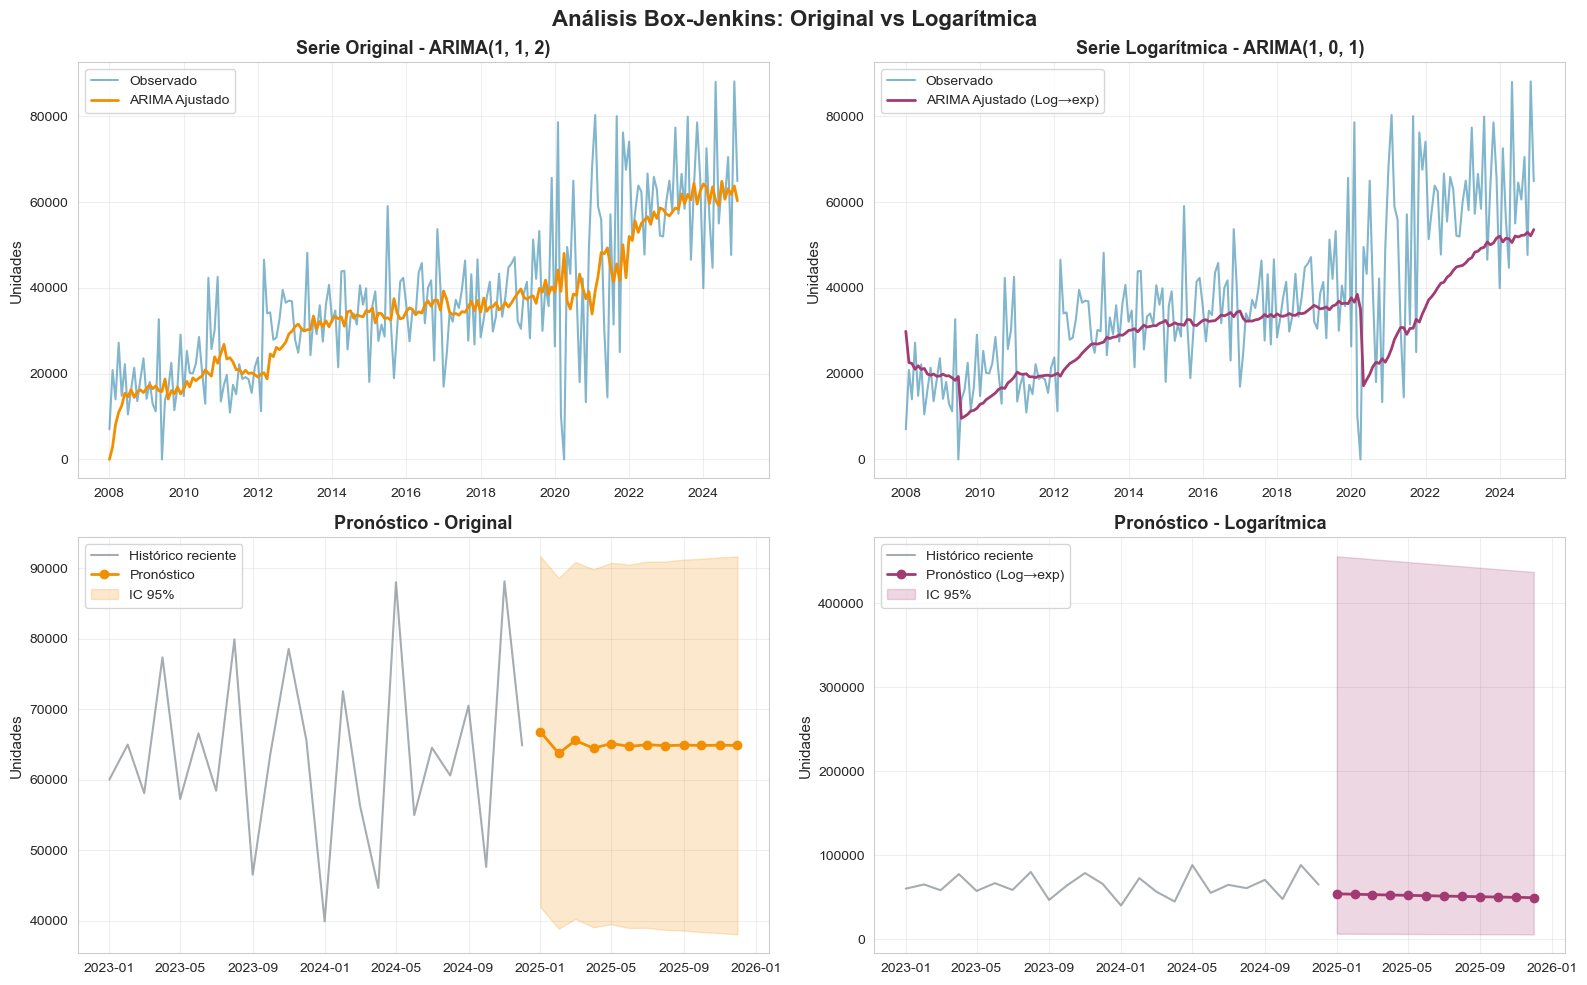


📈 COMPARACIÓN DE MÉTRICAS
                 Order          AIC          BIC          MAE          RMSE  \
Original     (1, 1, 2)  4409.500043  4422.752867  8903.510292  12326.403614   
Logarítmica  (1, 0, 1)   622.816085   636.088565     0.423135      1.091826   

                  MAPE  
Original     27.556085  
Logarítmica   3.134968  

✅ Mejor modelo: SERIE LOGARÍTMICA


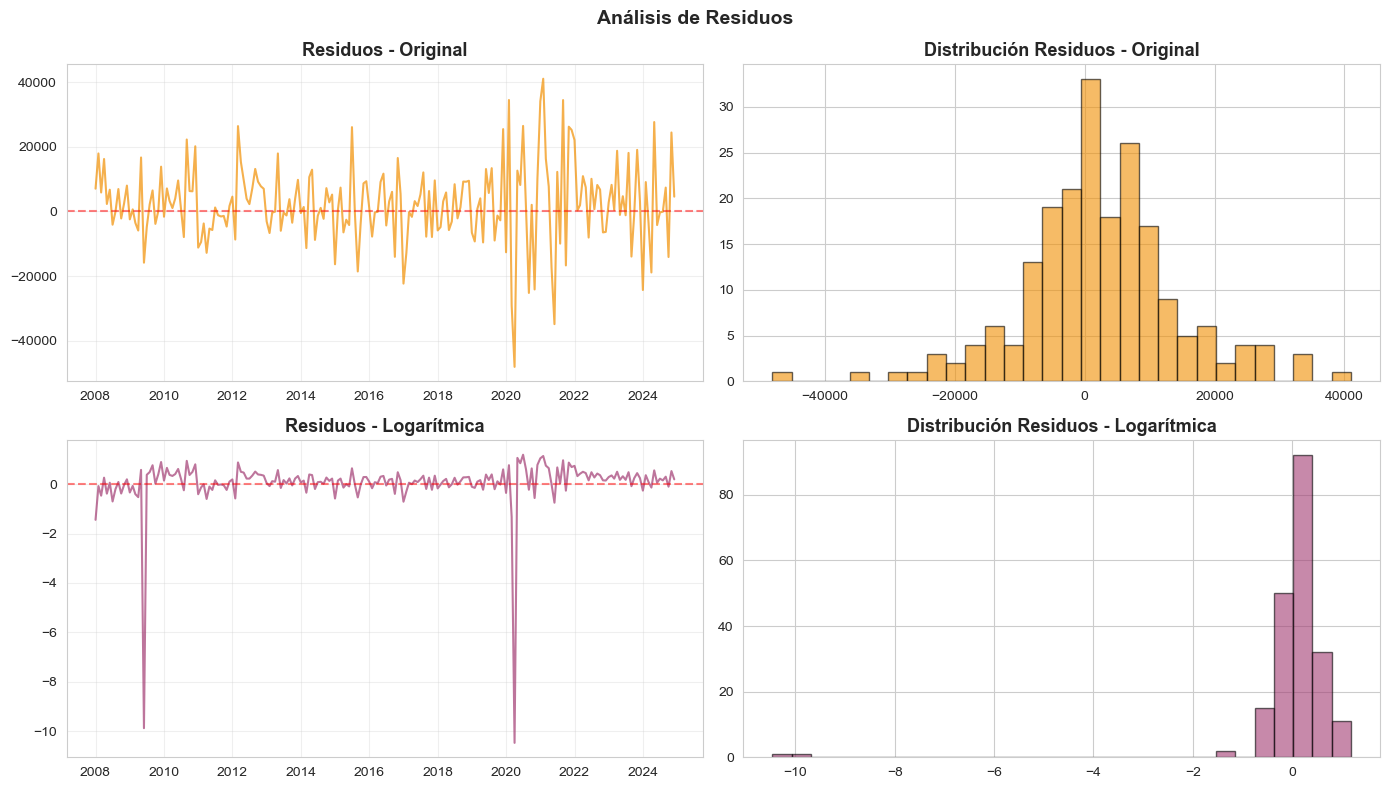


✅ Análisis completado exitosamente


In [4]:
# BOX–JENKINS COMPARATIVO: SERIE ORIGINAL vs LOGARÍTMICA
# Versión corregida y mejorada
# ===============================================================
import os, warnings, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

# Estilo profesional
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 13,
})

# ---------- CONFIG ----------
mainpath = "/Users/DELL/datasets"
filename = "VEN.csv"
FILE = os.path.join(mainpath, filename)

# ---------- UTILIDADES ----------
def safe_mape(y_true, y_pred):
    """Calcula MAPE evitando divisiones por cero"""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = (y_true != 0) & ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0: 
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def detect_d(series, max_d=2):
    """Detecta el orden de diferenciación necesario"""
    d = 0
    cur = series.copy()
    while d < max_d:
        try:
            adf_result = adfuller(cur.dropna())
            p_value = adf_result[1]
            if p_value <= 0.05:
                break
            cur = cur.diff().dropna()
            d += 1
        except:
            break
    return d

def fit_arima(series, d, max_p=2, max_q=2):
    """Encuentra el mejor modelo ARIMA según AIC"""
    best_aic, best_bic, best_order, best_mod = np.inf, np.inf, None, None
    
    for p, q in itertools.product(range(0, max_p + 1), range(0, max_q + 1)):
        try:
            mod = sm.tsa.ARIMA(series, order=(p, d, q)).fit()
            if mod.aic < best_aic:
                best_aic = mod.aic
                best_bic = mod.bic
                best_order = (p, d, q)
                best_mod = mod
        except:
            continue
    
    return best_mod, best_order, best_aic, best_bic

def resumen_modelo(nombre, serie, mod):
    """Calcula y muestra métricas del modelo"""
    resid = mod.resid.dropna()
    fitted = mod.fittedvalues
    common = serie.index.intersection(fitted.index)
    
    mae = mean_absolute_error(serie.loc[common], fitted.loc[common])
    rmse = mean_squared_error(serie.loc[common], fitted.loc[common], squared=False)
    mape = safe_mape(serie.loc[common], fitted.loc[common])
    
    print(f"\n--- {nombre} ---")
    print(f"Modelo: ARIMA{mod.specification['order']}")  # ✅ CORRECCIÓN
    print(f"AIC: {mod.aic:.2f} | BIC: {mod.bic:.2f}")
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
    
    return {
        "MAE": mae, 
        "RMSE": rmse, 
        "MAPE": mape, 
        "AIC": mod.aic,
        "BIC": mod.bic,
        "Order": str(mod.specification['order']),
        "resid": resid, 
        "fitted": fitted
    }

# ---------- FUNCION PRINCIPAL ----------
def box_jenkins_dual(file_path, col='UNIDADES', steps_forecast=12):
    """
    Realiza análisis Box-Jenkins comparativo entre serie original y logarítmica
    """
    # Cargar datos
    df = pd.read_csv(file_path)
    if not {'AÑO', 'MES', col}.issubset(df.columns):
        raise ValueError(f"El CSV debe contener columnas: AÑO, MES, {col}")
    
    df['FECHA'] = pd.to_datetime(dict(year=df['AÑO'], month=df['MES'], day=1))
    serie = df.groupby('FECHA')[col].sum().asfreq('MS').fillna(0)
    logserie = np.log1p(serie)

    print("\n" + "="*70)
    print("📊 ANÁLISIS BOX–JENKINS COMPARATIVO")
    print("="*70)
    print(f"Observaciones: {len(serie)} | Media: {serie.mean():,.2f} | Std: {serie.std():,.2f}")

    # ---- SERIE ORIGINAL ----
    print("\n🔍 Analizando serie ORIGINAL...")
    d_orig = detect_d(serie)
    print(f"Diferenciación detectada: d = {d_orig}")
    mod_orig, order_o, aic_o, bic_o = fit_arima(serie, d_orig)
    res_orig = resumen_modelo("Serie Original", serie, mod_orig)

    # ---- SERIE LOGARÍTMICA ----
    print("\n🔍 Analizando serie LOGARÍTMICA...")
    d_log = detect_d(logserie)
    print(f"Diferenciación detectada: d = {d_log}")
    mod_log, order_l, aic_l, bic_l = fit_arima(logserie, d_log)
    res_log = resumen_modelo("Serie Logarítmica (ln(1+x))", logserie, mod_log)

    # ---- PRONÓSTICOS ----
    forecast_o = mod_orig.get_forecast(steps=steps_forecast)
    forecast_l = mod_log.get_forecast(steps=steps_forecast)
    
    pred_o = forecast_o.predicted_mean
    conf_o = forecast_o.conf_int()
    
    pred_l_log = forecast_l.predicted_mean
    conf_l_log = forecast_l.conf_int()
    
    # Revertir transformación logarítmica
    pred_l = np.expm1(pred_l_log)
    conf_l_lower = np.expm1(conf_l_log.iloc[:, 0])
    conf_l_upper = np.expm1(conf_l_log.iloc[:, 1])

    print("\n" + "-"*70)
    print(f"🔮 Pronóstico comparativo a {steps_forecast} períodos")
    print("-"*70)
    print(f"Original - Media pronóstico: {pred_o.mean():,.2f}")
    print(f"Log→exp - Media pronóstico: {pred_l.mean():,.2f}")

    # ---- GRÁFICOS MEJORADOS ----
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Análisis Box-Jenkins: Original vs Logarítmica', 
                 fontsize=16, fontweight='bold')

    # 1. Serie Original con ajuste
    axes[0, 0].plot(serie, label='Observado', alpha=0.6, color='#2E86AB')
    axes[0, 0].plot(res_orig["fitted"], label='ARIMA Ajustado', 
                    color='#F18F01', linewidth=2)
    axes[0, 0].set_title(f'Serie Original - ARIMA{order_o}', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylabel('Unidades')

    # 2. Serie Log con ajuste (revertido a escala original)
    fitted_log_inv = np.expm1(res_log["fitted"])
    axes[0, 1].plot(serie, label='Observado', alpha=0.6, color='#2E86AB')
    axes[0, 1].plot(fitted_log_inv, label='ARIMA Ajustado (Log→exp)', 
                    color='#A23B72', linewidth=2)
    axes[0, 1].set_title(f'Serie Logarítmica - ARIMA{order_l}', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylabel('Unidades')

    # 3. Pronósticos - Original
    axes[1, 0].plot(serie[-24:], label='Histórico reciente', color='#6C757D', alpha=0.6)
    axes[1, 0].plot(pred_o, label='Pronóstico', color='#F18F01', 
                    linewidth=2, marker='o')
    axes[1, 0].fill_between(pred_o.index, 
                            conf_o.iloc[:, 0], 
                            conf_o.iloc[:, 1],
                            alpha=0.2, color='#F18F01', label='IC 95%')
    axes[1, 0].set_title('Pronóstico - Original', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylabel('Unidades')

    # 4. Pronósticos - Log (revertido)
    axes[1, 1].plot(serie[-24:], label='Histórico reciente', color='#6C757D', alpha=0.6)
    axes[1, 1].plot(pred_l, label='Pronóstico (Log→exp)', color='#A23B72', 
                    linewidth=2, marker='o')
    axes[1, 1].fill_between(pred_l.index, 
                            conf_l_lower, 
                            conf_l_upper,
                            alpha=0.2, color='#A23B72', label='IC 95%')
    axes[1, 1].set_title('Pronóstico - Logarítmica', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylabel('Unidades')

    plt.tight_layout()
    plt.show()

    # ---- TABLA COMPARATIVA ----
    print("\n" + "="*70)
    print("📈 COMPARACIÓN DE MÉTRICAS")
    print("="*70)
    
    tabla = pd.DataFrame({
        'Original': res_orig,
        'Logarítmica': res_log
    }).T
    
    print(tabla[["Order", "AIC", "BIC", "MAE", "RMSE", "MAPE"]].round(2))
    
    # Determinar mejor modelo
    if res_orig["MAPE"] < res_log["MAPE"]:
        print("\n✅ Mejor modelo: SERIE ORIGINAL")
    else:
        print("\n✅ Mejor modelo: SERIE LOGARÍTMICA")

    # ---- RESIDUOS ----
    fig_resid, axes_resid = plt.subplots(2, 2, figsize=(14, 8))
    fig_resid.suptitle('Análisis de Residuos', fontsize=14, fontweight='bold')
    
    # Residuos Original
    axes_resid[0, 0].plot(res_orig["resid"], color='#F18F01', alpha=0.7)
    axes_resid[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes_resid[0, 0].set_title('Residuos - Original', fontweight='bold')
    axes_resid[0, 0].grid(True, alpha=0.3)
    
    axes_resid[0, 1].hist(res_orig["resid"], bins=30, color='#F18F01', 
                          alpha=0.6, edgecolor='black')
    axes_resid[0, 1].set_title('Distribución Residuos - Original', fontweight='bold')
    
    # Residuos Log
    axes_resid[1, 0].plot(res_log["resid"], color='#A23B72', alpha=0.7)
    axes_resid[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes_resid[1, 0].set_title('Residuos - Logarítmica', fontweight='bold')
    axes_resid[1, 0].grid(True, alpha=0.3)
    
    axes_resid[1, 1].hist(res_log["resid"], bins=30, color='#A23B72', 
                          alpha=0.6, edgecolor='black')
    axes_resid[1, 1].set_title('Distribución Residuos - Logarítmica', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    return {
        "original": res_orig, 
        "log": res_log,
        "forecast_orig": pred_o,
        "forecast_log": pred_l,
        "conf_orig": conf_o,
        "conf_log": (conf_l_lower, conf_l_upper),
        "model_orig": mod_orig,
        "model_log": mod_log
    }

# ---------- EJECUTAR ----------
if __name__ == "__main__":
    resultados_dual = box_jenkins_dual(FILE, col='UNIDADES', steps_forecast=12)
    
    print("\n" + "="*70)
    print("✅ Análisis completado exitosamente")
    print("="*70)

In [75]:
### ensayo

In [5]:
df = pd.read_csv(FILE)
print(df.columns)
print(df.head())

Index(['CODIGO', 'AROMA', 'UNIDADES', 'CONCEPTO', 'MES', 'AÑO'], dtype='object')
  CODIGO                          AROMA  UNIDADES     CONCEPTO  MES   AÑO
0    VEN  INCIENSO BHARATH DARSHAN X 25      50.0  FACTURA VTA   12  2008
1    VEN  INCIENSO BHARATH DARSHAN X 25       2.0  FACTURA VTA   12  2008
2    VEN  INCIENSO BHARATH DARSHAN X 25       5.0  FACTURA VTA   12  2008
3    VEN  INCIENSO BHARATH DARSHAN X 25     100.0  FACTURA VTA   12  2008
4    VEN  INCIENSO BHARATH DARSHAN X 25      25.0  FACTURA VTA   12  2008


INFORMACIÓN GENERAL DEL DATASET

Dimensiones originales: (413474, 6)

Primeras filas:
  CODIGO                          AROMA  UNIDADES     CONCEPTO  MES   AÑO
0    VEN  INCIENSO BHARATH DARSHAN X 25      50.0  FACTURA VTA   12  2008
1    VEN  INCIENSO BHARATH DARSHAN X 25       2.0  FACTURA VTA   12  2008
2    VEN  INCIENSO BHARATH DARSHAN X 25       5.0  FACTURA VTA   12  2008
3    VEN  INCIENSO BHARATH DARSHAN X 25     100.0  FACTURA VTA   12  2008
4    VEN  INCIENSO BHARATH DARSHAN X 25      25.0  FACTURA VTA   12  2008
5    VEN  INCIENSO BHARATH DARSHAN X 25      10.0  FACTURA VTA   12  2008
6    VEN  INCIENSO BHARATH DARSHAN X 25       5.0  FACTURA VTA   12  2008
7    VEN  INCIENSO BHARATH DARSHAN X 25       5.0  FACTURA VTA   12  2008
8    VEN  INCIENSO BHARATH DARSHAN X 25      20.0  FACTURA VTA   12  2008
9    VEN  INCIENSO BHARATH DARSHAN X 25       1.0  FACTURA VTA   12  2008

Columnas: ['CODIGO', 'AROMA', 'UNIDADES', 'CONCEPTO', 'MES', 'AÑO']

Tipos de conceptos: ['FACTURA 

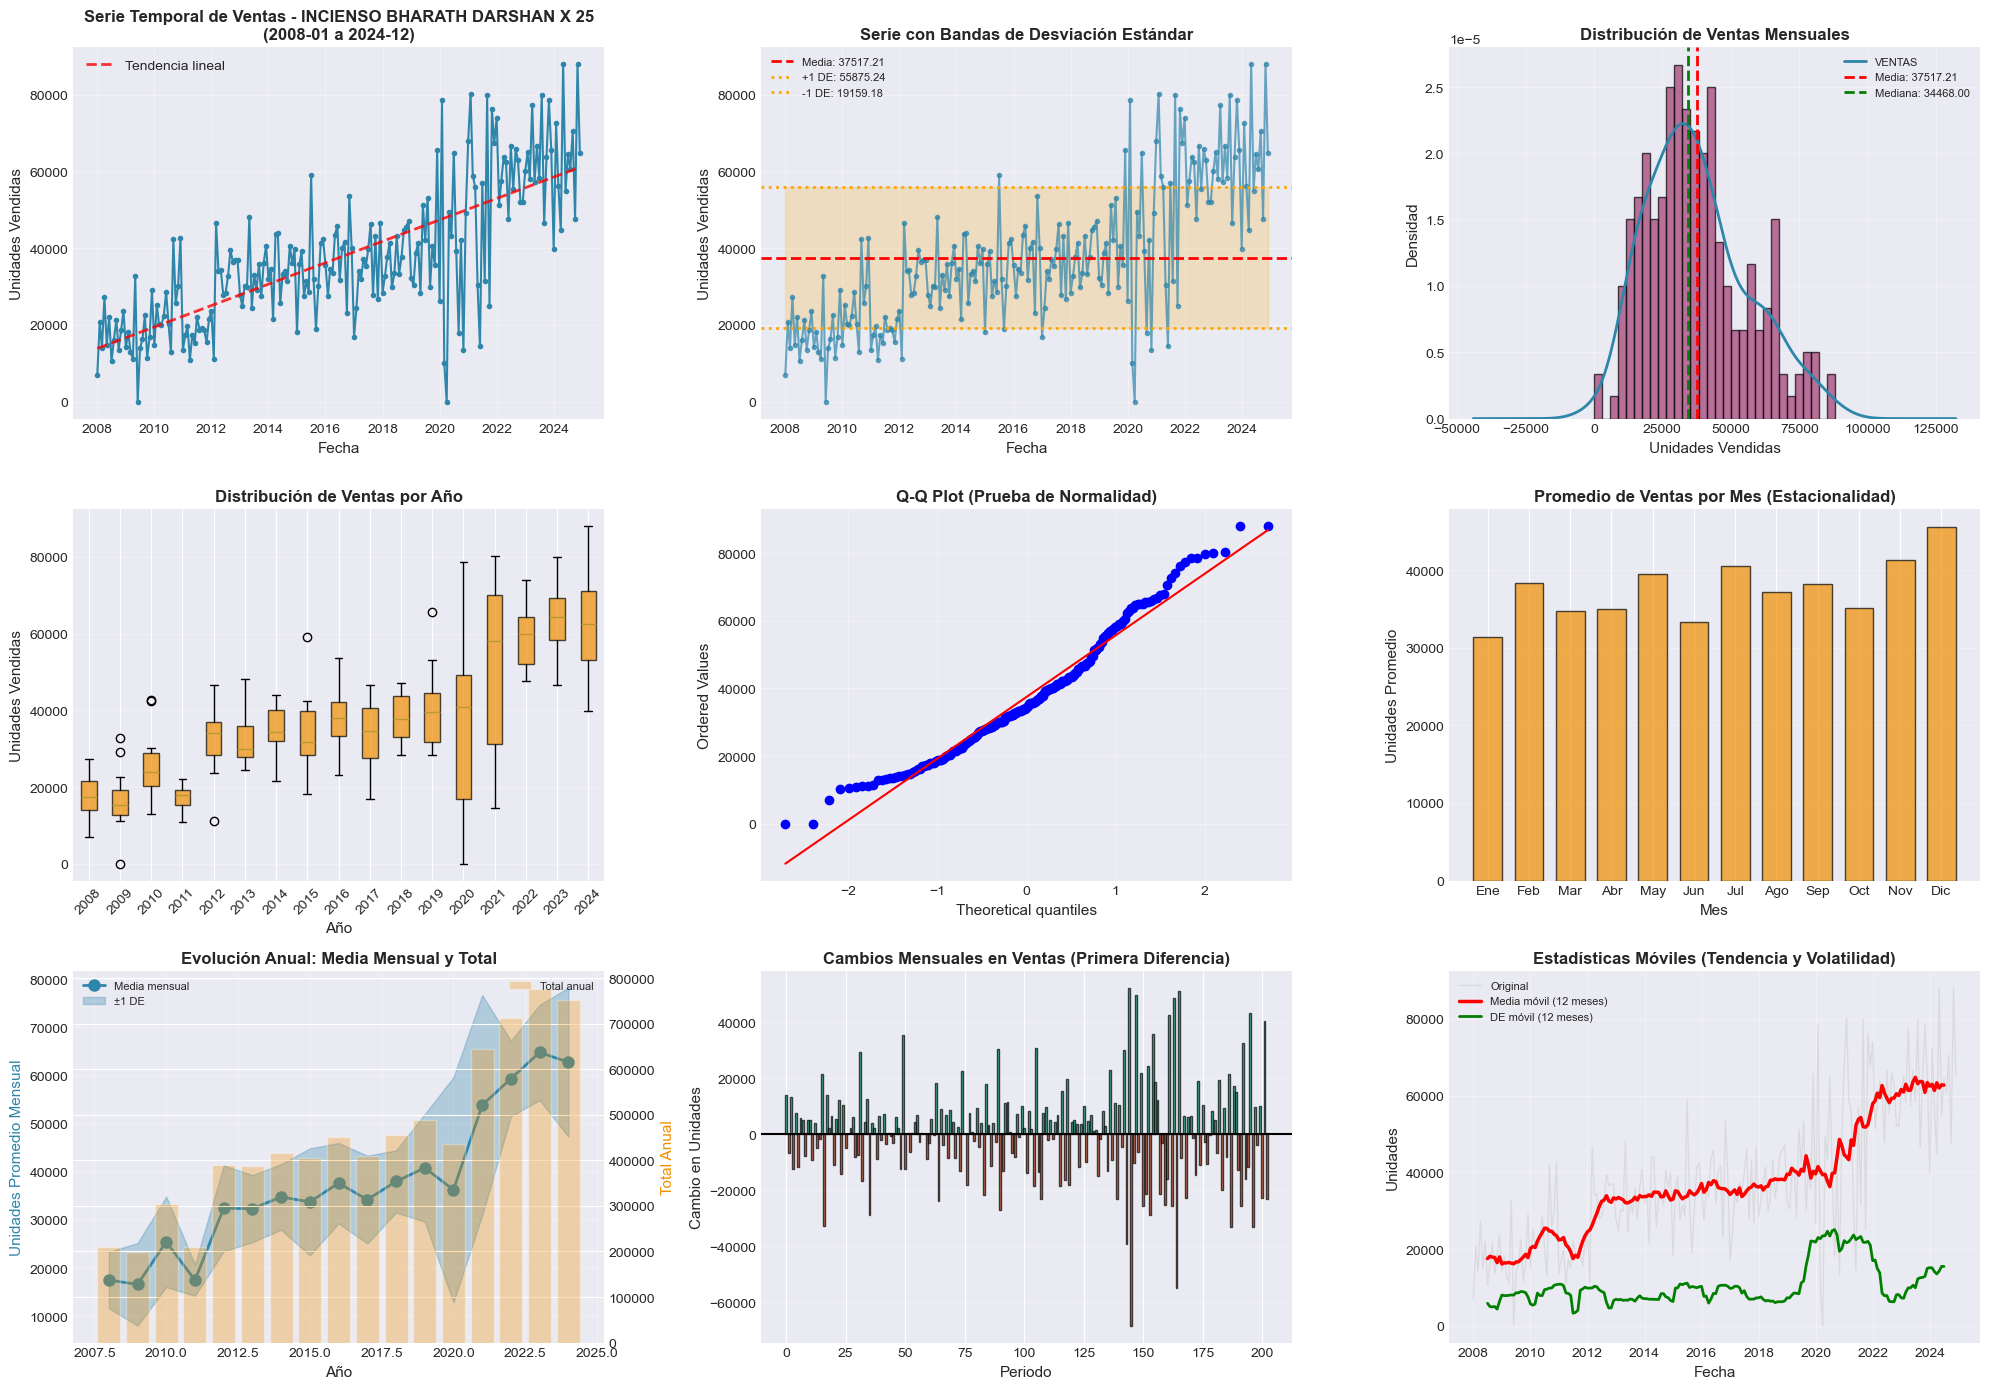


✓ Gráfico guardado en: /Users/DELL/datasets\analisis_exploratorio_ventas_incienso.png

ANÁLISIS DE TENDENCIA

Modelo de tendencia lineal: Y = 13893.20 + 232.7489*X
Pendiente (β₁): 232.7489 unidades/mes
Intercepto (β₀): 13893.20
R² (coeficiente de determinación): 0.5602
  → El modelo explica el 56.02% de la variabilidad
Correlación (r): 0.7485
p-value: 0.000000
Error estándar: 14.5107

✓ Tendencia ESTADÍSTICAMENTE SIGNIFICATIVA (α=0.05)
  → Tendencia CRECIENTE: las ventas aumentan en promedio 232.75 unidades por mes
  → Incremento anual estimado: 2792.99 unidades

Proyección lineal (próximos 12 meses):
  Mes +1: 61606.72 unidades
  Mes +2: 61839.47 unidades
  Mes +3: 62072.22 unidades
  Mes +4: 62304.97 unidades
  Mes +5: 62537.72 unidades
  Mes +6: 62770.47 unidades
  Mes +7: 63003.21 unidades
  Mes +8: 63235.96 unidades
  Mes +9: 63468.71 unidades
  Mes +10: 63701.46 unidades
  Mes +11: 63934.21 unidades
  Mes +12: 64166.96 unidades

RESUMEN EJECUTIVO

Producto: INCIENSO BHARATH DARS

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# ==========================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ==========================================

mainpath = "/Users/DELL/datasets"
filename = "VEN.csv"
FILE = os.path.join(mainpath, filename)

# Cargar datos
df = pd.read_csv(FILE)

print("="*60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*60)
print(f"\nDimensiones originales: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head(10))
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nTipos de conceptos: {df['CONCEPTO'].unique()}")
print(f"\nTipos de aroma: {df['AROMA'].unique()}")
print(f"\nRango de años: {df['AÑO'].min()} - {df['AÑO'].max()}")
print(f"\nValores nulos:")
print(df.isnull().sum())

# ==========================================
# 2. PROCESAMIENTO Y AGREGACIÓN
# ==========================================

# Crear columna de fecha
df['FECHA'] = pd.to_datetime(df['AÑO'].astype(str) + '-' + df['MES'].astype(str) + '-01')

# Filtrar solo ventas (puedes incluir otros conceptos si es necesario)
print(f"\nConceptos disponibles: {df['CONCEPTO'].value_counts()}")
df_ventas = df[df['CONCEPTO'] == 'FACTURA VTA'].copy()

# Agregar ventas por mes (suma de unidades vendidas)
serie_mensual = df_ventas.groupby('FECHA')['UNIDADES'].sum().sort_index()

# Crear DataFrame con la serie temporal
ts_df = pd.DataFrame({
    'FECHA': serie_mensual.index,
    'VENTAS': serie_mensual.values
})
ts_df.set_index('FECHA', inplace=True)

# Rellenar meses faltantes con 0 (si no hubo ventas)
date_range = pd.date_range(start=ts_df.index.min(), end=ts_df.index.max(), freq='MS')
ts_df = ts_df.reindex(date_range, fill_value=0)

print("\n" + "="*60)
print("SERIE TEMPORAL PROCESADA")
print("="*60)
print(f"\nPeriodo: {ts_df.index.min().strftime('%Y-%m')} a {ts_df.index.max().strftime('%Y-%m')}")
print(f"Total de meses: {len(ts_df)}")
print(f"Meses con ventas: {(ts_df['VENTAS'] > 0).sum()}")
print(f"Meses sin ventas: {(ts_df['VENTAS'] == 0).sum()}")
print(f"\nPrimeros registros mensuales:")
print(ts_df.head(15))
print(f"\nÚltimos registros mensuales:")
print(ts_df.tail(15))

# ==========================================
# 3. ESTADÍSTICAS DESCRIPTIVAS COMPLETAS
# ==========================================

print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS - VENTAS MENSUALES")
print("="*60)

serie = ts_df['VENTAS']

# Estadísticas básicas
stats_dict = {
    'Media': serie.mean(),
    'Mediana': serie.median(),
    'Moda': serie.mode().values[0] if len(serie.mode()) > 0 else np.nan,
    'Desviación Estándar': serie.std(),
    'Varianza': serie.var(),
    'Coeficiente de Variación (%)': (serie.std() / serie.mean()) * 100 if serie.mean() != 0 else 0,
    'Mínimo': serie.min(),
    'Máximo': serie.max(),
    'Rango': serie.max() - serie.min(),
    'Q1 (25%)': serie.quantile(0.25),
    'Q2 (50% - Mediana)': serie.quantile(0.50),
    'Q3 (75%)': serie.quantile(0.75),
    'Rango Intercuartílico (IQR)': serie.quantile(0.75) - serie.quantile(0.25),
    'Asimetría (Skewness)': serie.skew(),
    'Curtosis (Kurtosis)': serie.kurtosis(),
    'Total de observaciones': len(serie),
    'Valores únicos': serie.nunique(),
    'Suma total de ventas': serie.sum()
}

stats_df = pd.DataFrame(stats_dict.items(), columns=['Estadística', 'Valor'])
print("\n", stats_df.to_string(index=False))

# Interpretación de asimetría y curtosis
print("\n" + "-"*60)
print("INTERPRETACIÓN DE DISTRIBUCIÓN")
print("-"*60)
skew_val = serie.skew()
kurt_val = serie.kurtosis()

if abs(skew_val) < 0.5:
    skew_interp = "aproximadamente simétrica"
elif skew_val > 0.5:
    skew_interp = "sesgada a la derecha (cola larga hacia valores altos)"
else:
    skew_interp = "sesgada a la izquierda (cola larga hacia valores bajos)"

if abs(kurt_val) < 0.5:
    kurt_interp = "distribución mesocúrtica (similar a normal)"
elif kurt_val > 0.5:
    kurt_interp = "distribución leptocúrtica (más puntiaguda, colas pesadas)"
else:
    kurt_interp = "distribución platicúrtica (más plana)"

print(f"\nAsimetría: {skew_val:.3f} → {skew_interp}")
print(f"Curtosis: {kurt_val:.3f} → {kurt_interp}")

# Prueba de normalidad (solo si hay más de 3 observaciones)
if len(serie) > 3:
    _, p_value_shapiro = stats.shapiro(serie)
    print(f"\nPrueba de normalidad Shapiro-Wilk:")
    print(f"  p-value: {p_value_shapiro:.6f}")
    print(f"  Interpretación: {'La serie parece seguir distribución normal (α=0.05)' if p_value_shapiro > 0.05 else 'La serie NO sigue distribución normal (α=0.05)'}")

# Identificar outliers (método IQR)
Q1 = serie.quantile(0.25)
Q3 = serie.quantile(0.75)
IQR = Q3 - Q1
outliers = serie[(serie < Q1 - 1.5 * IQR) | (serie > Q3 + 1.5 * IQR)]
print(f"\nOutliers detectados (método IQR): {len(outliers)}")
if len(outliers) > 0:
    print(f"Valores atípicos: {outliers.values}")
    print(f"Fechas con outliers: {outliers.index.strftime('%Y-%m').tolist()}")

# ==========================================
# 4. VISUALIZACIONES COMPLETAS
# ==========================================

fig = plt.figure(figsize=(20, 14))

# 4.1 Serie temporal completa
ax1 = plt.subplot(3, 3, 1)
ax1.plot(serie.index, serie.values, linewidth=1.5, color='#2E86AB', marker='o', markersize=3)
ax1.set_title(f'Serie Temporal de Ventas - {df["AROMA"].iloc[0]}\n({serie.index.min().strftime("%Y-%m")} a {serie.index.max().strftime("%Y-%m")})', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Unidades Vendidas')
ax1.grid(True, alpha=0.3)

# Agregar línea de tendencia
if len(serie) > 1:
    z = np.polyfit(range(len(serie)), serie.values, 1)
    p = np.poly1d(z)
    ax1.plot(serie.index, p(range(len(serie))), "r--", alpha=0.8, linewidth=2, label=f'Tendencia lineal')
    ax1.legend()

# 4.2 Serie con media y bandas de desviación estándar
ax2 = plt.subplot(3, 3, 2)
ax2.plot(serie.index, serie.values, linewidth=1.5, alpha=0.7, color='#2E86AB', marker='o', markersize=3)
ax2.axhline(y=serie.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {serie.mean():.2f}')
ax2.axhline(y=serie.mean() + serie.std(), color='orange', linestyle=':', linewidth=2, label=f'+1 DE: {serie.mean() + serie.std():.2f}')
ax2.axhline(y=serie.mean() - serie.std(), color='orange', linestyle=':', linewidth=2, label=f'-1 DE: {serie.mean() - serie.std():.2f}')
ax2.fill_between(serie.index, serie.mean() - serie.std(), serie.mean() + serie.std(), alpha=0.2, color='orange')
ax2.set_title('Serie con Bandas de Desviación Estándar', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Unidades Vendidas')
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)

# 4.3 Histograma con curva de densidad
ax3 = plt.subplot(3, 3, 3)
ax3.hist(serie, bins=30, density=True, alpha=0.7, color='#A23B72', edgecolor='black')
if serie.std() > 0:  # Solo si hay variabilidad
    serie.plot(kind='kde', ax=ax3, color='#2E86AB', linewidth=2)
ax3.axvline(serie.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {serie.mean():.2f}')
ax3.axvline(serie.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {serie.median():.2f}')
ax3.set_title('Distribución de Ventas Mensuales', fontsize=12, fontweight='bold')
ax3.set_xlabel('Unidades Vendidas')
ax3.set_ylabel('Densidad')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4.4 Box plot por año
ax4 = plt.subplot(3, 3, 4)
ts_plot = ts_df.copy()
ts_plot['Año'] = ts_plot.index.year
box_data = [ts_plot[ts_plot['Año'] == year]['VENTAS'].values for year in sorted(ts_plot['Año'].unique())]
bp = ax4.boxplot(box_data, labels=sorted(ts_plot['Año'].unique()), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#F18F01')
    patch.set_alpha(0.7)
ax4.set_title('Distribución de Ventas por Año', fontsize=12, fontweight='bold')
ax4.set_xlabel('Año')
ax4.set_ylabel('Unidades Vendidas')
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

# 4.5 Q-Q plot (normalidad)
ax5 = plt.subplot(3, 3, 5)
stats.probplot(serie, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot (Prueba de Normalidad)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 4.6 Serie por mes (estacionalidad visual)
ax6 = plt.subplot(3, 3, 6)
ts_plot['Mes'] = ts_plot.index.month
monthly_avg = ts_plot.groupby('Mes')['VENTAS'].mean()
ax6.bar(monthly_avg.index, monthly_avg.values, color='#F18F01', alpha=0.7, edgecolor='black', width=0.7)
ax6.set_title('Promedio de Ventas por Mes (Estacionalidad)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Mes')
ax6.set_ylabel('Unidades Promedio')
ax6.set_xticks(range(1, 13))
ax6.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
ax6.grid(True, alpha=0.3, axis='y')

# 4.7 Evolución anual con variabilidad
ax7 = plt.subplot(3, 3, 7)
yearly_stats = ts_plot.groupby('Año')['VENTAS'].agg(['mean', 'std', 'min', 'max', 'sum'])
ax7.plot(yearly_stats.index, yearly_stats['mean'], marker='o', linewidth=2, markersize=8, label='Media mensual', color='#2E86AB')
ax7.fill_between(yearly_stats.index, 
                  yearly_stats['mean'] - yearly_stats['std'], 
                  yearly_stats['mean'] + yearly_stats['std'], 
                  alpha=0.3, label='±1 DE', color='#2E86AB')
ax7_twin = ax7.twinx()
ax7_twin.bar(yearly_stats.index, yearly_stats['sum'], alpha=0.3, color='#F18F01', label='Total anual')
ax7.set_title('Evolución Anual: Media Mensual y Total', fontsize=12, fontweight='bold')
ax7.set_xlabel('Año')
ax7.set_ylabel('Unidades Promedio Mensual', color='#2E86AB')
ax7_twin.set_ylabel('Total Anual', color='#F18F01')
ax7.legend(loc='upper left', fontsize=8)
ax7_twin.legend(loc='upper right', fontsize=8)
ax7.grid(True, alpha=0.3)

# 4.8 Cambios absolutos (primera diferencia)
ax8 = plt.subplot(3, 3, 8)
cambios = serie.diff().dropna()
colors = ['#C73E1D' if x < 0 else '#06A77D' for x in cambios.values]
ax8.bar(range(len(cambios)), cambios.values, color=colors, alpha=0.7, edgecolor='black', width=0.8)
ax8.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax8.set_title('Cambios Mensuales en Ventas (Primera Diferencia)', fontsize=12, fontweight='bold')
ax8.set_xlabel('Periodo')
ax8.set_ylabel('Cambio en Unidades')
ax8.grid(True, alpha=0.3, axis='y')

# 4.9 Estadísticas móviles (media móvil)
ax9 = plt.subplot(3, 3, 9)
window_size = min(12, len(serie) // 3)  # Adaptativo según longitud de serie
rolling_mean = serie.rolling(window=window_size, center=True).mean()
rolling_std = serie.rolling(window=window_size, center=True).std()
ax9.plot(serie.index, serie.values, linewidth=1, alpha=0.5, label='Original', color='#cccccc')
ax9.plot(rolling_mean.index, rolling_mean.values, linewidth=2.5, color='red', label=f'Media móvil ({window_size} meses)')
ax9.plot(rolling_std.index, rolling_std.values, linewidth=2, color='green', label=f'DE móvil ({window_size} meses)')
ax9.set_title('Estadísticas Móviles (Tendencia y Volatilidad)', fontsize=12, fontweight='bold')
ax9.set_xlabel('Fecha')
ax9.set_ylabel('Unidades')
ax9.legend(fontsize=8)
ax9.grid(True, alpha=0.3)

plt.tight_layout()
output_file = os.path.join(mainpath, 'analisis_exploratorio_ventas_incienso.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado en: {output_file}")

# ==========================================
# 5. ANÁLISIS DE TENDENCIA
# ==========================================

print("\n" + "="*60)
print("ANÁLISIS DE TENDENCIA")
print("="*60)

if len(serie) > 1:
    # Regresión lineal para tendencia
    X_range = np.arange(len(serie))
    slope, intercept, r_value, p_value, std_err = stats.linregress(X_range, serie.values)
    
    print(f"\nModelo de tendencia lineal: Y = {intercept:.2f} + {slope:.4f}*X")
    print(f"Pendiente (β₁): {slope:.4f} unidades/mes")
    print(f"Intercepto (β₀): {intercept:.2f}")
    print(f"R² (coeficiente de determinación): {r_value**2:.4f}")
    print(f"  → El modelo explica el {r_value**2*100:.2f}% de la variabilidad")
    print(f"Correlación (r): {r_value:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Error estándar: {std_err:.4f}")
    
    if p_value < 0.05:
        print(f"\n✓ Tendencia ESTADÍSTICAMENTE SIGNIFICATIVA (α=0.05)")
        if slope > 0:
            print(f"  → Tendencia CRECIENTE: las ventas aumentan en promedio {slope:.2f} unidades por mes")
            print(f"  → Incremento anual estimado: {slope*12:.2f} unidades")
        else:
            print(f"  → Tendencia DECRECIENTE: las ventas disminuyen en promedio {abs(slope):.2f} unidades por mes")
            print(f"  → Reducción anual estimada: {abs(slope)*12:.2f} unidades")
    else:
        print(f"\n✗ NO hay tendencia estadísticamente significativa (α=0.05)")
        print(f"  → Las ventas se mantienen relativamente estables en el tiempo")
    
    # Proyección simple
    print(f"\nProyección lineal (próximos 12 meses):")
    for i in range(1, 13):
        future_value = intercept + slope * (len(serie) + i)
        print(f"  Mes +{i}: {max(0, future_value):.2f} unidades")

# ==========================================
# 6. RESUMEN EJECUTIVO
# ==========================================

print("\n" + "="*60)
print("RESUMEN EJECUTIVO")
print("="*60)
print(f"\nProducto: {df['AROMA'].iloc[0]}")
print(f"Periodo analizado: {serie.index.min().strftime('%B %Y')} - {serie.index.max().strftime('%B %Y')}")
print(f"Total meses analizados: {len(serie)}")
print(f"\nVentas totales: {serie.sum():.0f} unidades")
print(f"Promedio mensual: {serie.mean():.2f} ± {serie.std():.2f} unidades")
print(f"Mes con mayores ventas: {serie.idxmax().strftime('%B %Y')} ({serie.max():.0f} unidades)")
print(f"Mes con menores ventas: {serie.idxmin().strftime('%B %Y')} ({serie.min():.0f} unidades)")
print(f"Variabilidad: {'Alta' if stats_dict['Coeficiente de Variación (%)'] > 50 else 'Media' if stats_dict['Coeficiente de Variación (%)'] > 25 else 'Baja'} (CV={stats_dict['Coeficiente de Variación (%)']:.2f}%)")

print("\n" + "="*60)
print("ANÁLISIS COMPLETADO ✓")
print("="*60)

# Guardar serie temporal procesada para análisis posteriores
ts_df.to_csv(os.path.join(mainpath, 'serie_temporal_ventas.csv'))
print(f"\n✓ Serie temporal guardada en: {os.path.join(mainpath, 'serie_temporal_ventas.csv')}")

FASE 2: IDENTIFICACIÓN DE FACTORES DE VARIABILIDAD

2.1 ANÁLISIS DE VARIANZA POR PERIODOS

📊 VOLATILIDAD POR AÑO:
         Media   Mediana  Desv_Std      Varianza   CV_%       Min       Max  \
AÑO                                                                           
2008  17508.50  17476.00   5845.02  3.416427e+07  33.38   7034.00  27219.00   
2009  16613.75  15198.00   8578.20  7.358554e+07  51.63      0.00  32694.00   
2010  25443.67  23836.50   9395.83  8.828168e+07  36.93  12994.00  42571.00   
2011  17496.56  18032.71   3261.65  1.063834e+07  18.64  10928.86  22201.36   
2012  32410.00  34161.50   8922.76  7.961573e+07  27.53  11229.00  46575.00   
2013  32332.75  30040.50   6961.64  4.846444e+07  21.53  24307.00  48181.00   
2014  34758.08  34369.50   6807.75  4.634542e+07  19.59  21486.00  43969.00   
2015  33732.67  31712.50  11108.68  1.234029e+08  32.93  18082.00  59077.00   
2016  37616.00  37879.00   8342.52  6.959758e+07  22.18  23058.00  53687.00   
2017  34214.83  3

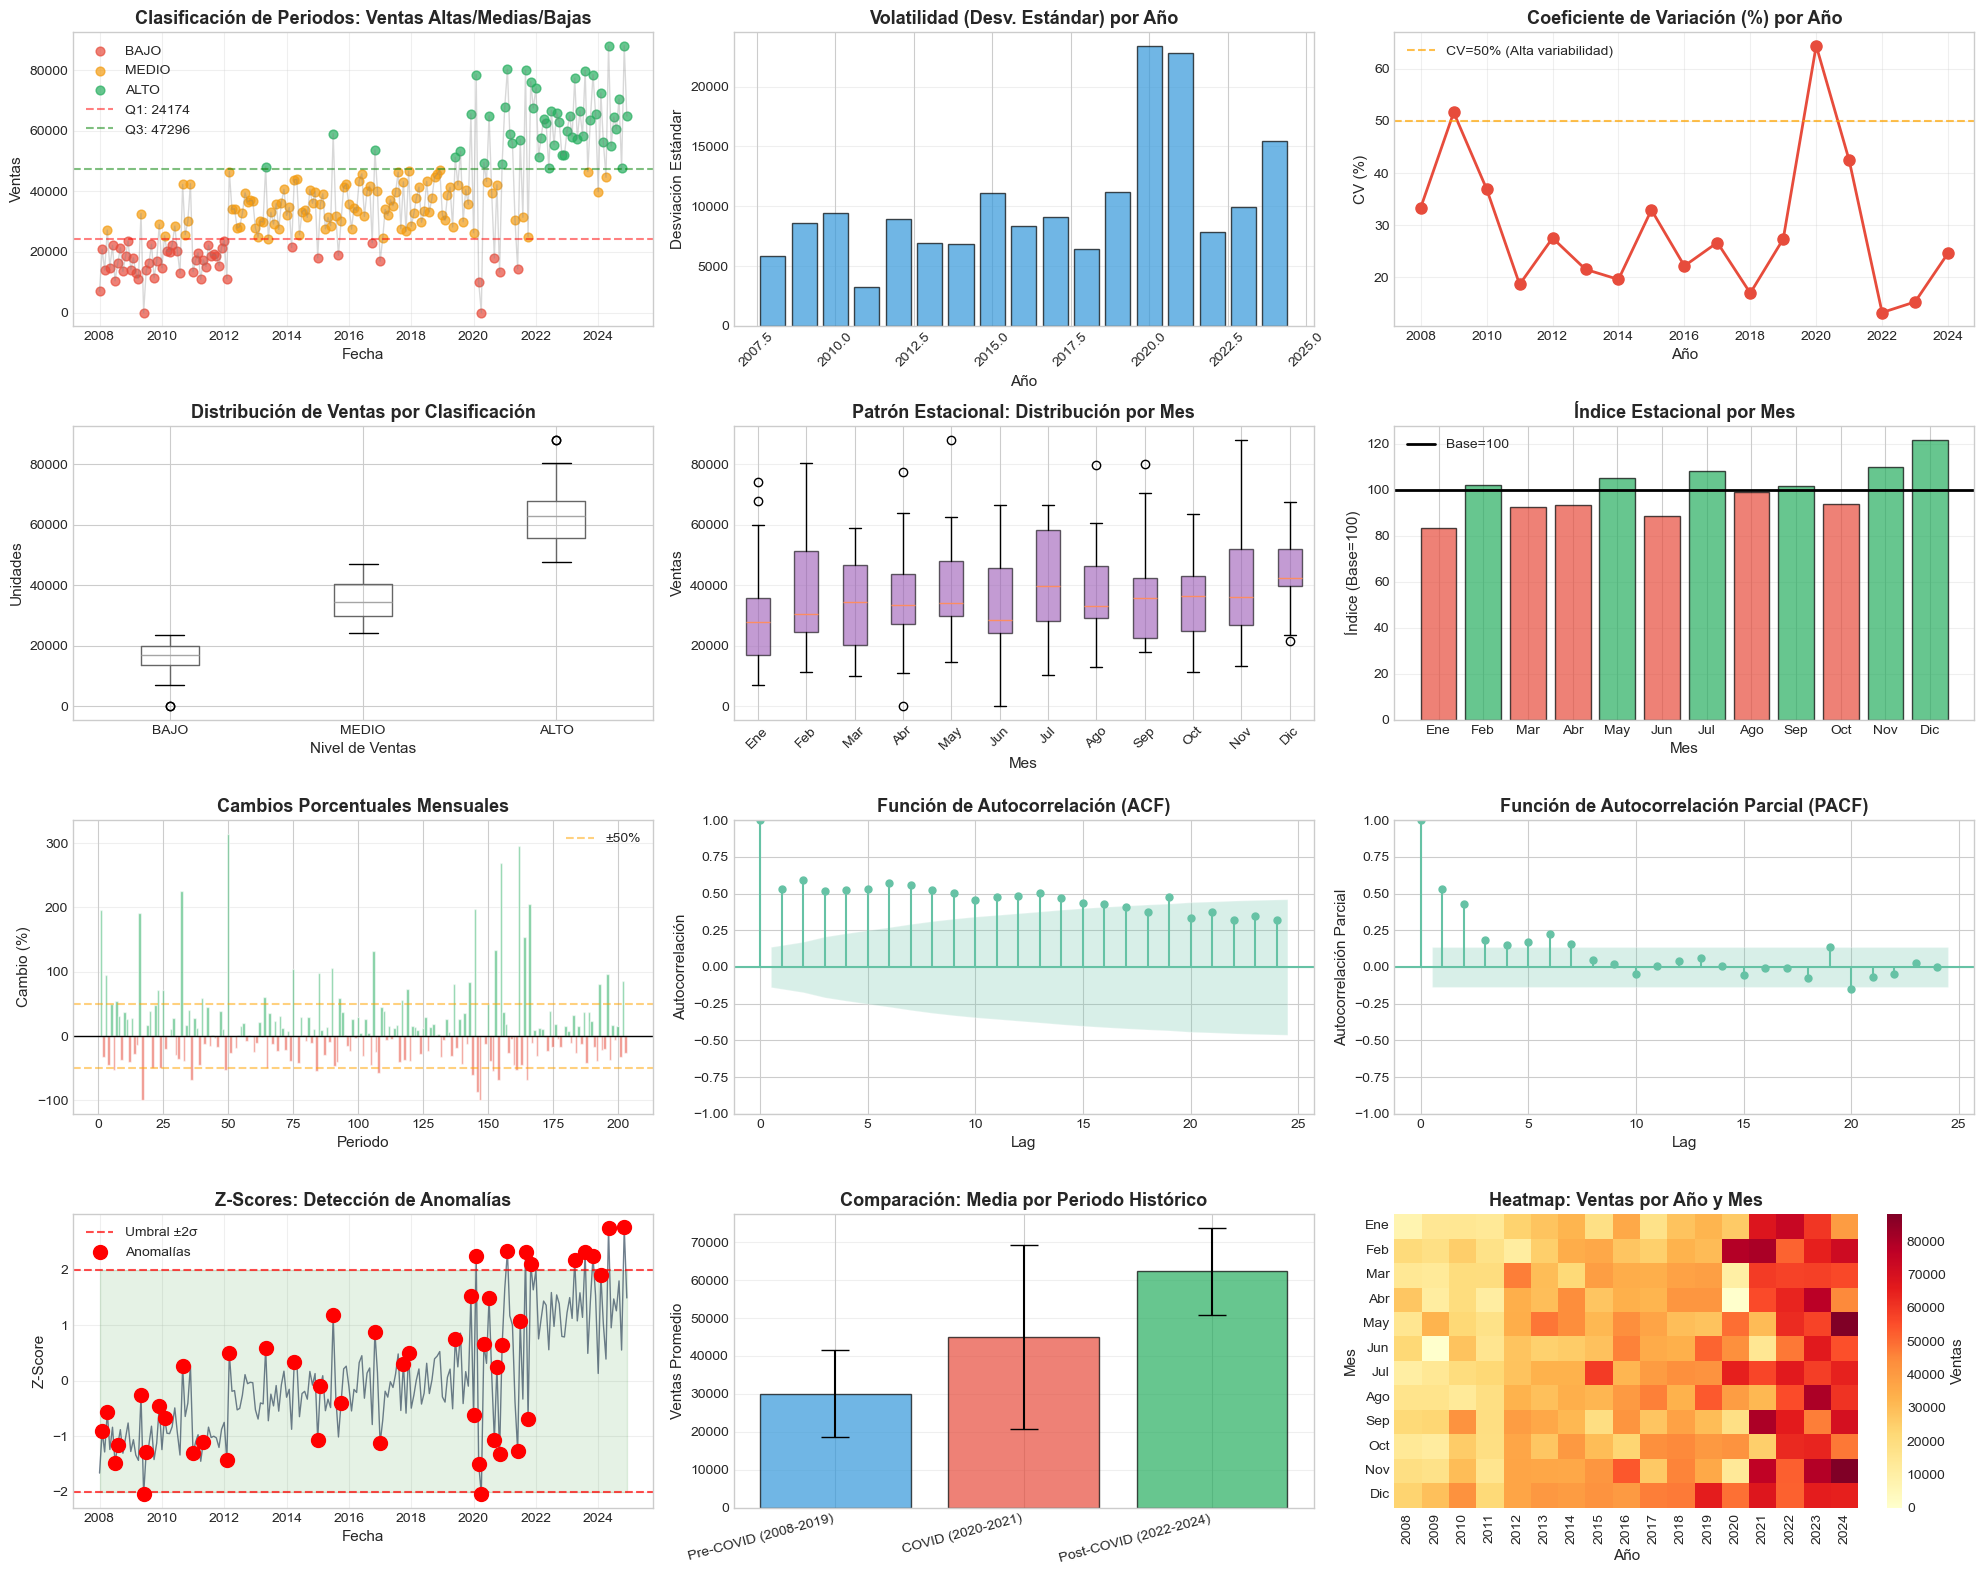


✓ Visualizaciones guardadas en: /Users/DELL/datasets\analisis_variabilidad_factores.png

RESUMEN: FACTORES IDENTIFICADOS DE VARIABILIDAD

1. VOLATILIDAD TEMPORAL:
   • Mayor volatilidad en 2020 (σ=23364.73)
   • Heterogeneidad de varianzas: SÍ

2. ESTACIONALIDAD:
   • Estacionalidad significativa: NO
   • Mes de mayor demanda: Dic
   • Mes de menor demanda: Ene

3. CAMBIOS ESTRUCTURALES:
   • Cambio Pre-COVID vs Post-COVID: SIGNIFICATIVO
   • Anomalías detectadas: 48

4. TENDENCIA:
   • Tendencia creciente confirmada (análisis previo)
   • Correlación año-a-año (lag 12): 0.553

ANÁLISIS DE VARIABILIDAD COMPLETADO ✓

✓ Datos guardados:
   • /Users/DELL/datasets\serie_con_analisis_variabilidad.csv
   • /Users/DELL/datasets\volatilidad_anual.csv
   • /Users/DELL/datasets\estacionalidad_mensual.csv


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, levene, kruskal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['font.size'] = 10

# ==========================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ==========================================

mainpath = "/Users/DELL/datasets"
filename = "VEN.csv"
FILE = os.path.join(mainpath, filename)

# Cargar datos
df = pd.read_csv(FILE)

# Crear fecha y agregar por mes
df['FECHA'] = pd.to_datetime(df['AÑO'].astype(str) + '-' + df['MES'].astype(str) + '-01')
df_ventas = df[df['CONCEPTO'] == 'FACTURA VTA'].copy()

# Serie temporal mensual
serie_mensual = df_ventas.groupby('FECHA')['UNIDADES'].sum().sort_index()
date_range = pd.date_range(start=serie_mensual.index.min(), end=serie_mensual.index.max(), freq='MS')
ts_df = pd.DataFrame({'VENTAS': serie_mensual}).reindex(date_range, fill_value=0)
ts_df.index.name = 'FECHA'

# Agregar características temporales
ts_df['AÑO'] = ts_df.index.year
ts_df['MES'] = ts_df.index.month
ts_df['TRIMESTRE'] = ts_df.index.quarter
ts_df['MES_NOMBRE'] = ts_df.index.strftime('%B')

print("="*80)
print("FASE 2: IDENTIFICACIÓN DE FACTORES DE VARIABILIDAD")
print("="*80)

# ==========================================
# 2. ANÁLISIS DE VARIANZA Y VOLATILIDAD
# ==========================================

print("\n" + "="*80)
print("2.1 ANÁLISIS DE VARIANZA POR PERIODOS")
print("="*80)

# Calcular volatilidad por año (desviación estándar)
volatilidad_anual = ts_df.groupby('AÑO')['VENTAS'].agg([
    ('Media', 'mean'),
    ('Mediana', 'median'),
    ('Desv_Std', 'std'),
    ('Varianza', 'var'),
    ('CV_%', lambda x: (x.std() / x.mean() * 100) if x.mean() != 0 else 0),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Rango', lambda x: x.max() - x.min())
])

print("\n📊 VOLATILIDAD POR AÑO:")
print(volatilidad_anual.round(2))

# Identificar años con mayor y menor volatilidad
año_max_vol = volatilidad_anual['Desv_Std'].idxmax()
año_min_vol = volatilidad_anual['Desv_Std'].idxmin()

print(f"\n🔴 Año con MAYOR volatilidad: {año_max_vol} (σ = {volatilidad_anual.loc[año_max_vol, 'Desv_Std']:.2f})")
print(f"🟢 Año con MENOR volatilidad: {año_min_vol} (σ = {volatilidad_anual.loc[año_min_vol, 'Desv_Std']:.2f})")

# Análisis de cambio en volatilidad (prueba de Levene)
grupos_años = [ts_df[ts_df['AÑO'] == año]['VENTAS'].values for año in ts_df['AÑO'].unique()]
stat_levene, p_levene = levene(*grupos_años)
print(f"\n📈 Prueba de Levene (homogeneidad de varianzas):")
print(f"   Estadístico: {stat_levene:.4f}, p-value: {p_levene:.6f}")
print(f"   Interpretación: {'Varianzas HETEROGÉNEAS entre años' if p_levene < 0.05 else 'Varianzas homogéneas entre años'}")

# ==========================================
# 3. CLASIFICACIÓN DE PERIODOS (ALTO/BAJO)
# ==========================================

print("\n" + "="*80)
print("2.2 COMPARACIÓN: PERIODOS DE VENTAS ALTAS vs BAJAS")
print("="*80)

# Clasificar periodos según percentiles
Q1 = ts_df['VENTAS'].quantile(0.25)
Q3 = ts_df['VENTAS'].quantile(0.75)
mediana = ts_df['VENTAS'].median()

ts_df['CLASIFICACION'] = pd.cut(ts_df['VENTAS'], 
                                 bins=[-np.inf, Q1, Q3, np.inf],
                                 labels=['BAJO', 'MEDIO', 'ALTO'])

# Estadísticas por clasificación
stats_por_nivel = ts_df.groupby('CLASIFICACION')['VENTAS'].describe()
print("\n📊 ESTADÍSTICAS POR NIVEL DE VENTAS:")
print(stats_por_nivel)

# Contar periodos por clasificación
conteo_periodos = ts_df['CLASIFICACION'].value_counts().sort_index()
print(f"\n📅 DISTRIBUCIÓN DE PERIODOS:")
for nivel, count in conteo_periodos.items():
    pct = (count / len(ts_df)) * 100
    print(f"   {nivel}: {count} meses ({pct:.1f}%)")

# Prueba ANOVA para diferencias significativas
grupos_nivel = [ts_df[ts_df['CLASIFICACION'] == nivel]['VENTAS'].values 
                for nivel in ['BAJO', 'MEDIO', 'ALTO']]
stat_anova, p_anova = f_oneway(*grupos_nivel)
print(f"\n📈 Prueba ANOVA (diferencias entre niveles):")
print(f"   F-estadístico: {stat_anova:.4f}, p-value: {p_anova:.6f}")
print(f"   Interpretación: {'Diferencias SIGNIFICATIVAS entre niveles' if p_anova < 0.05 else 'Sin diferencias significativas'}")

# ==========================================
# 4. IDENTIFICACIÓN DE EVENTOS EXTERNOS
# ==========================================

print("\n" + "="*80)
print("2.3 IDENTIFICACIÓN DE EVENTOS Y ANOMALÍAS")
print("="*80)

# Eventos económicos y sociales relevantes en Colombia/Mundial
eventos_externos = {
    '2008-09': 'Crisis Financiera Global',
    '2020-03': 'Inicio Pandemia COVID-19',
    '2020-04': 'Confinamiento Estricto',
    '2021-05': 'Paro Nacional Colombia',
    '2022-01': 'Post-pandemia / Reactivación',
    '2023-01': 'Nuevo Gobierno Colombia'
}

# Detectar cambios abruptos (anomalías estadísticas)
ts_df['CAMBIO_PCT'] = ts_df['VENTAS'].pct_change() * 100
ts_df['Z_SCORE'] = (ts_df['VENTAS'] - ts_df['VENTAS'].mean()) / ts_df['VENTAS'].std()

# Anomalías: Z-score > 2 o cambio > 50%
anomalias = ts_df[(np.abs(ts_df['Z_SCORE']) > 2) | (np.abs(ts_df['CAMBIO_PCT']) > 50)]

print(f"\n🚨 ANOMALÍAS DETECTADAS (|Z-score| > 2 o cambio > 50%): {len(anomalias)}")
if len(anomalias) > 0:
    print("\nTop 10 anomalías más significativas:")
    anomalias_sorted = anomalias.sort_values('Z_SCORE', ascending=False, key=abs).head(10)
    for idx, row in anomalias_sorted.iterrows():
        fecha_str = idx.strftime('%Y-%m')
        evento = eventos_externos.get(fecha_str, '')
        print(f"   {fecha_str}: {row['VENTAS']:.0f} unidades (Z={row['Z_SCORE']:.2f}, Δ={row['CAMBIO_PCT']:.1f}%) {evento}")

# Análisis de caídas y picos extremos
print("\n📉 TOP 5 CAÍDAS MÁS PRONUNCIADAS:")
caidas = ts_df.nsmallest(5, 'CAMBIO_PCT')[['VENTAS', 'CAMBIO_PCT']]
for idx, row in caidas.iterrows():
    fecha_str = idx.strftime('%Y-%m')
    evento = eventos_externos.get(fecha_str, '')
    print(f"   {fecha_str}: {row['CAMBIO_PCT']:.1f}% ({row['VENTAS']:.0f} unidades) {evento}")

print("\n📈 TOP 5 PICOS MÁS PRONUNCIADOS:")
picos = ts_df.nlargest(5, 'CAMBIO_PCT')[['VENTAS', 'CAMBIO_PCT']]
for idx, row in picos.iterrows():
    fecha_str = idx.strftime('%Y-%m')
    evento = eventos_externos.get(fecha_str, '')
    print(f"   {fecha_str}: {row['CAMBIO_PCT']:.1f}% ({row['VENTAS']:.0f} unidades) {evento}")

# ==========================================
# 5. ANÁLISIS DE ESTACIONALIDAD
# ==========================================

print("\n" + "="*80)
print("2.4 ANÁLISIS DE ESTACIONALIDAD (Patrón Intra-Anual)")
print("="*80)

# Estadísticas por mes
stats_por_mes = ts_df.groupby('MES')['VENTAS'].agg([
    ('Media', 'mean'),
    ('Mediana', 'median'),
    ('Desv_Std', 'std'),
    ('CV_%', lambda x: (x.std() / x.mean() * 100) if x.mean() != 0 else 0)
])

print("\n📅 ESTADÍSTICAS POR MES DEL AÑO:")
meses_nombres = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
stats_por_mes.index = meses_nombres
print(stats_por_mes.round(2))

# Identificar meses de mayor y menor demanda
mes_max = stats_por_mes['Media'].idxmax()
mes_min = stats_por_mes['Media'].idxmin()
print(f"\n🔴 Mes con MAYOR demanda promedio: {mes_max} ({stats_por_mes.loc[mes_max, 'Media']:.2f} unidades)")
print(f"🟢 Mes con MENOR demanda promedio: {mes_min} ({stats_por_mes.loc[mes_min, 'Media']:.2f} unidades)")

# Prueba de Kruskal-Wallis (diferencias entre meses)
grupos_meses = [ts_df[ts_df['MES'] == mes]['VENTAS'].values for mes in range(1, 13)]
stat_kruskal, p_kruskal = kruskal(*grupos_meses)
print(f"\n📈 Prueba de Kruskal-Wallis (diferencias entre meses):")
print(f"   H-estadístico: {stat_kruskal:.4f}, p-value: {p_kruskal:.6f}")
print(f"   Interpretación: {'Existe ESTACIONALIDAD significativa' if p_kruskal < 0.05 else 'Sin estacionalidad significativa'}")

# Índice estacional
media_global = ts_df['VENTAS'].mean()
indice_estacional = (stats_por_mes['Media'] / media_global) * 100
print(f"\n📊 ÍNDICE ESTACIONAL (Base=100):")
for mes, idx in indice_estacional.items():
    tendencia = "📈" if idx > 105 else "📉" if idx < 95 else "➡️"
    print(f"   {mes}: {idx:.1f} {tendencia}")

# ==========================================
# 6. ANÁLISIS DE CORRELACIÓN TEMPORAL
# ==========================================

print("\n" + "="*80)
print("2.5 CORRELACIÓN TEMPORAL Y AUTOCORRELACIÓN")
print("="*80)

# Calcular autocorrelaciones
from statsmodels.tsa.stattools import acf, pacf

lags = 24
acf_values = acf(ts_df['VENTAS'].dropna(), nlags=lags)
pacf_values = pacf(ts_df['VENTAS'].dropna(), nlags=lags)

print(f"\n📊 AUTOCORRELACIONES SIGNIFICATIVAS (primeros 12 lags):")
for lag in range(1, 13):
    if abs(acf_values[lag]) > 1.96/np.sqrt(len(ts_df)):  # Umbral de significancia
        print(f"   Lag {lag}: {acf_values[lag]:.3f} {'✓ SIGNIFICATIVA' if abs(acf_values[lag]) > 0.2 else ''}")

# Correlación con ventas del año anterior (lag 12)
if len(ts_df) >= 12:
    ts_df['VENTAS_LAG12'] = ts_df['VENTAS'].shift(12)
    corr_anual = ts_df[['VENTAS', 'VENTAS_LAG12']].corr().iloc[0, 1]
    print(f"\n📈 Correlación con mismo mes del año anterior: {corr_anual:.3f}")
    print(f"   Interpretación: {'Fuerte patrón estacional anual' if corr_anual > 0.5 else 'Patrón estacional débil o inexistente'}")

# ==========================================
# 7. ANÁLISIS DE CAMBIO ESTRUCTURAL
# ==========================================

print("\n" + "="*80)
print("2.6 DETECCIÓN DE CAMBIOS ESTRUCTURALES")
print("="*80)

# Dividir serie en periodos y comparar medias
periodos = {
    'Pre-COVID (2008-2019)': ts_df[(ts_df.index.year >= 2008) & (ts_df.index.year <= 2019)]['VENTAS'],
    'COVID (2020-2021)': ts_df[(ts_df.index.year >= 2020) & (ts_df.index.year <= 2021)]['VENTAS'],
    'Post-COVID (2022-2024)': ts_df[(ts_df.index.year >= 2022) & (ts_df.index.year <= 2024)]['VENTAS']
}

print("\n📊 COMPARACIÓN POR PERIODOS HISTÓRICOS:")
for periodo, datos in periodos.items():
    if len(datos) > 0:
        print(f"\n{periodo}:")
        print(f"   Media: {datos.mean():.2f} unidades")
        print(f"   Mediana: {datos.median():.2f} unidades")
        print(f"   Desv. Std: {datos.std():.2f}")
        print(f"   CV: {(datos.std()/datos.mean()*100):.2f}%")

# Prueba t para diferencias entre periodos
if len(periodos['Pre-COVID (2008-2019)']) > 0 and len(periodos['Post-COVID (2022-2024)']) > 0:
    stat_t, p_t = stats.ttest_ind(periodos['Pre-COVID (2008-2019)'], 
                                    periodos['Post-COVID (2022-2024)'])
    print(f"\n📈 Prueba t (Pre-COVID vs Post-COVID):")
    print(f"   t-estadístico: {stat_t:.4f}, p-value: {p_t:.6f}")
    print(f"   Interpretación: {'Cambio ESTRUCTURAL significativo' if p_t < 0.05 else 'Sin cambio estructural significativo'}")

# ==========================================
# 8. VISUALIZACIONES
# ==========================================

fig = plt.figure(figsize=(20, 16))

# 8.1 Evolución con clasificación de periodos
ax1 = plt.subplot(4, 3, 1)
colors_map = {'BAJO': '#e74c3c', 'MEDIO': '#f39c12', 'ALTO': '#27ae60'}
for nivel in ['BAJO', 'MEDIO', 'ALTO']:
    data = ts_df[ts_df['CLASIFICACION'] == nivel]
    ax1.scatter(data.index, data['VENTAS'], c=colors_map[nivel], label=nivel, alpha=0.7, s=40)
ax1.plot(ts_df.index, ts_df['VENTAS'], linewidth=1, alpha=0.3, color='gray')
ax1.axhline(y=Q1, color='red', linestyle='--', alpha=0.5, label=f'Q1: {Q1:.0f}')
ax1.axhline(y=Q3, color='green', linestyle='--', alpha=0.5, label=f'Q3: {Q3:.0f}')
ax1.set_title('Clasificación de Periodos: Ventas Altas/Medias/Bajas', fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ventas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 8.2 Volatilidad por año
ax2 = plt.subplot(4, 3, 2)
ax2.bar(volatilidad_anual.index, volatilidad_anual['Desv_Std'], color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_title('Volatilidad (Desv. Estándar) por Año', fontweight='bold')
ax2.set_xlabel('Año')
ax2.set_ylabel('Desviación Estándar')
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 8.3 Coeficiente de variación por año
ax3 = plt.subplot(4, 3, 3)
ax3.plot(volatilidad_anual.index, volatilidad_anual['CV_%'], marker='o', linewidth=2, markersize=8, color='#e74c3c')
ax3.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='CV=50% (Alta variabilidad)')
ax3.set_title('Coeficiente de Variación (%) por Año', fontweight='bold')
ax3.set_xlabel('Año')
ax3.set_ylabel('CV (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 8.4 Box plot por clasificación
ax4 = plt.subplot(4, 3, 4)
ts_df.boxplot(column='VENTAS', by='CLASIFICACION', ax=ax4)
ax4.set_title('Distribución de Ventas por Clasificación', fontweight='bold')
ax4.set_xlabel('Nivel de Ventas')
ax4.set_ylabel('Unidades')
plt.suptitle('')

# 8.5 Patrón estacional (box plot por mes)
ax5 = plt.subplot(4, 3, 5)
monthly_data = [ts_df[ts_df['MES'] == mes]['VENTAS'].values for mes in range(1, 13)]
bp = ax5.boxplot(monthly_data, labels=meses_nombres, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#9b59b6')
    patch.set_alpha(0.6)
ax5.set_title('Patrón Estacional: Distribución por Mes', fontweight='bold')
ax5.set_xlabel('Mes')
ax5.set_ylabel('Ventas')
ax5.grid(True, alpha=0.3, axis='y')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)

# 8.6 Índice estacional
ax6 = plt.subplot(4, 3, 6)
colors_idx = ['#27ae60' if x > 100 else '#e74c3c' for x in indice_estacional.values]
ax6.bar(indice_estacional.index, indice_estacional.values, color=colors_idx, alpha=0.7, edgecolor='black')
ax6.axhline(y=100, color='black', linestyle='-', linewidth=2, label='Base=100')
ax6.set_title('Índice Estacional por Mes', fontweight='bold')
ax6.set_xlabel('Mes')
ax6.set_ylabel('Índice (Base=100)')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 8.7 Cambios porcentuales
ax7 = plt.subplot(4, 3, 7)
colors_cambio = ['#27ae60' if x > 0 else '#e74c3c' for x in ts_df['CAMBIO_PCT'].values]
ax7.bar(range(len(ts_df)), ts_df['CAMBIO_PCT'].values, color=colors_cambio, alpha=0.6, width=1)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax7.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='±50%')
ax7.axhline(y=-50, color='orange', linestyle='--', alpha=0.5)
ax7.set_title('Cambios Porcentuales Mensuales', fontweight='bold')
ax7.set_xlabel('Periodo')
ax7.set_ylabel('Cambio (%)')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# 8.8 ACF (Autocorrelación)
ax8 = plt.subplot(4, 3, 8)
plot_acf(ts_df['VENTAS'].dropna(), lags=24, ax=ax8, alpha=0.05)
ax8.set_title('Función de Autocorrelación (ACF)', fontweight='bold')
ax8.set_xlabel('Lag')
ax8.set_ylabel('Autocorrelación')

# 8.9 PACF (Autocorrelación Parcial)
ax9 = plt.subplot(4, 3, 9)
plot_pacf(ts_df['VENTAS'].dropna(), lags=24, ax=ax9, alpha=0.05, method='ywm')
ax9.set_title('Función de Autocorrelación Parcial (PACF)', fontweight='bold')
ax9.set_xlabel('Lag')
ax9.set_ylabel('Autocorrelación Parcial')

# 8.10 Z-scores (anomalías)
ax10 = plt.subplot(4, 3, 10)
ax10.plot(ts_df.index, ts_df['Z_SCORE'], linewidth=1, color='#34495e', alpha=0.7)
ax10.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Umbral ±2σ')
ax10.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
ax10.fill_between(ts_df.index, -2, 2, alpha=0.1, color='green')
ax10.scatter(anomalias.index, anomalias['Z_SCORE'], color='red', s=100, zorder=5, label='Anomalías')
ax10.set_title('Z-Scores: Detección de Anomalías', fontweight='bold')
ax10.set_xlabel('Fecha')
ax10.set_ylabel('Z-Score')
ax10.legend()
ax10.grid(True, alpha=0.3)

# 8.11 Comparación por periodos históricos
ax11 = plt.subplot(4, 3, 11)
periodos_nombres = list(periodos.keys())
periodos_medias = [datos.mean() for datos in periodos.values()]
periodos_std = [datos.std() for datos in periodos.values()]
ax11.bar(periodos_nombres, periodos_medias, yerr=periodos_std, capsize=10, 
         color=['#3498db', '#e74c3c', '#27ae60'], alpha=0.7, edgecolor='black')
ax11.set_title('Comparación: Media por Periodo Histórico', fontweight='bold')
ax11.set_ylabel('Ventas Promedio')
ax11.grid(True, alpha=0.3, axis='y')
plt.setp(ax11.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 8.12 Heatmap: Ventas por Año-Mes
ax12 = plt.subplot(4, 3, 12)
pivot_table = ts_df.pivot_table(values='VENTAS', index='MES', columns='AÑO', aggfunc='sum')
pivot_table.index = meses_nombres
sns.heatmap(pivot_table, annot=False, fmt='.0f', cmap='YlOrRd', ax=ax12, cbar_kws={'label': 'Ventas'})
ax12.set_title('Heatmap: Ventas por Año y Mes', fontweight='bold')
ax12.set_xlabel('Año')
ax12.set_ylabel('Mes')

plt.tight_layout()
output_file = os.path.join(mainpath, 'analisis_variabilidad_factores.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualizaciones guardadas en: {output_file}")

# ==========================================
# 9. RESUMEN DE FACTORES DE VARIABILIDAD
# ==========================================

print("\n" + "="*80)
print("RESUMEN: FACTORES IDENTIFICADOS DE VARIABILIDAD")
print("="*80)

print("\n1. VOLATILIDAD TEMPORAL:")
print(f"   • Mayor volatilidad en {año_max_vol} (σ={volatilidad_anual.loc[año_max_vol, 'Desv_Std']:.2f})")
print(f"   • Heterogeneidad de varianzas: {'SÍ' if p_levene < 0.05 else 'NO'}")

print("\n2. ESTACIONALIDAD:")
print(f"   • Estacionalidad significativa: {'SÍ' if p_kruskal < 0.05 else 'NO'}")
print(f"   • Mes de mayor demanda: {mes_max}")
print(f"   • Mes de menor demanda: {mes_min}")

print("\n3. CAMBIOS ESTRUCTURALES:")
print(f"   • Cambio Pre-COVID vs Post-COVID: {'SIGNIFICATIVO' if p_t < 0.05 else 'NO SIGNIFICATIVO'}")
print(f"   • Anomalías detectadas: {len(anomalias)}")

print("\n4. TENDENCIA:")
print(f"   • Tendencia creciente confirmada (análisis previo)")
print(f"   • Correlación año-a-año (lag 12): {corr_anual:.3f}" if len(ts_df) >= 12 else "")

print("\n" + "="*80)
print("ANÁLISIS DE VARIABILIDAD COMPLETADO ✓")
print("="*80)

# Guardar resultados
ts_df.to_csv(os.path.join(mainpath, 'serie_con_analisis_variabilidad.csv'))
volatilidad_anual.to_csv(os.path.join(mainpath, 'volatilidad_anual.csv'))
stats_por_mes.to_csv(os.path.join(mainpath, 'estacionalidad_mensual.csv'))

print(f"\n✓ Datos guardados:")
print(f"   • {os.path.join(mainpath, 'serie_con_analisis_variabilidad.csv')}")
print(f"   • {os.path.join(mainpath, 'volatilidad_anual.csv')}")
print(f"   • {os.path.join(mainpath, 'estacionalidad_mensual.csv')}")

ANÁLISIS DE PATRÓN DE VENTAS POR MES

Periodo analizado: 2008-01 a 2024-12
Total de meses: 204
Total años completos: 17

ESTADÍSTICAS DE VENTAS POR MES DEL AÑO
            Promedio  Mediana     Total  Desv_Std   Minimo   Maximo  Índice_Estacional  Variación_%
Enero        31355.0  27916.0  533042.0   19442.0   7034.0  74077.0               83.6        -16.4
Febrero      38316.0  30473.0  651366.0   22490.0  11229.0  80289.0              102.1          2.1
Marzo        34738.0  34661.0  590549.0   16669.0  10183.0  58970.0               92.6         -7.4
Abril        35015.0  33658.0  595249.0   19469.0      0.0  77368.0               93.3         -6.7
Mayo         39515.0  34275.0  671753.0   18105.0  14828.0  88012.0              105.3          5.3
Junio        33253.0  28656.0  565300.0   16764.0      0.0  66581.0               88.6        -11.4
Julio        40557.0  39698.0  689477.0   18533.0  10501.0  66665.0              108.1          8.1
Agosto       37176.0  33289.0  631987.0 

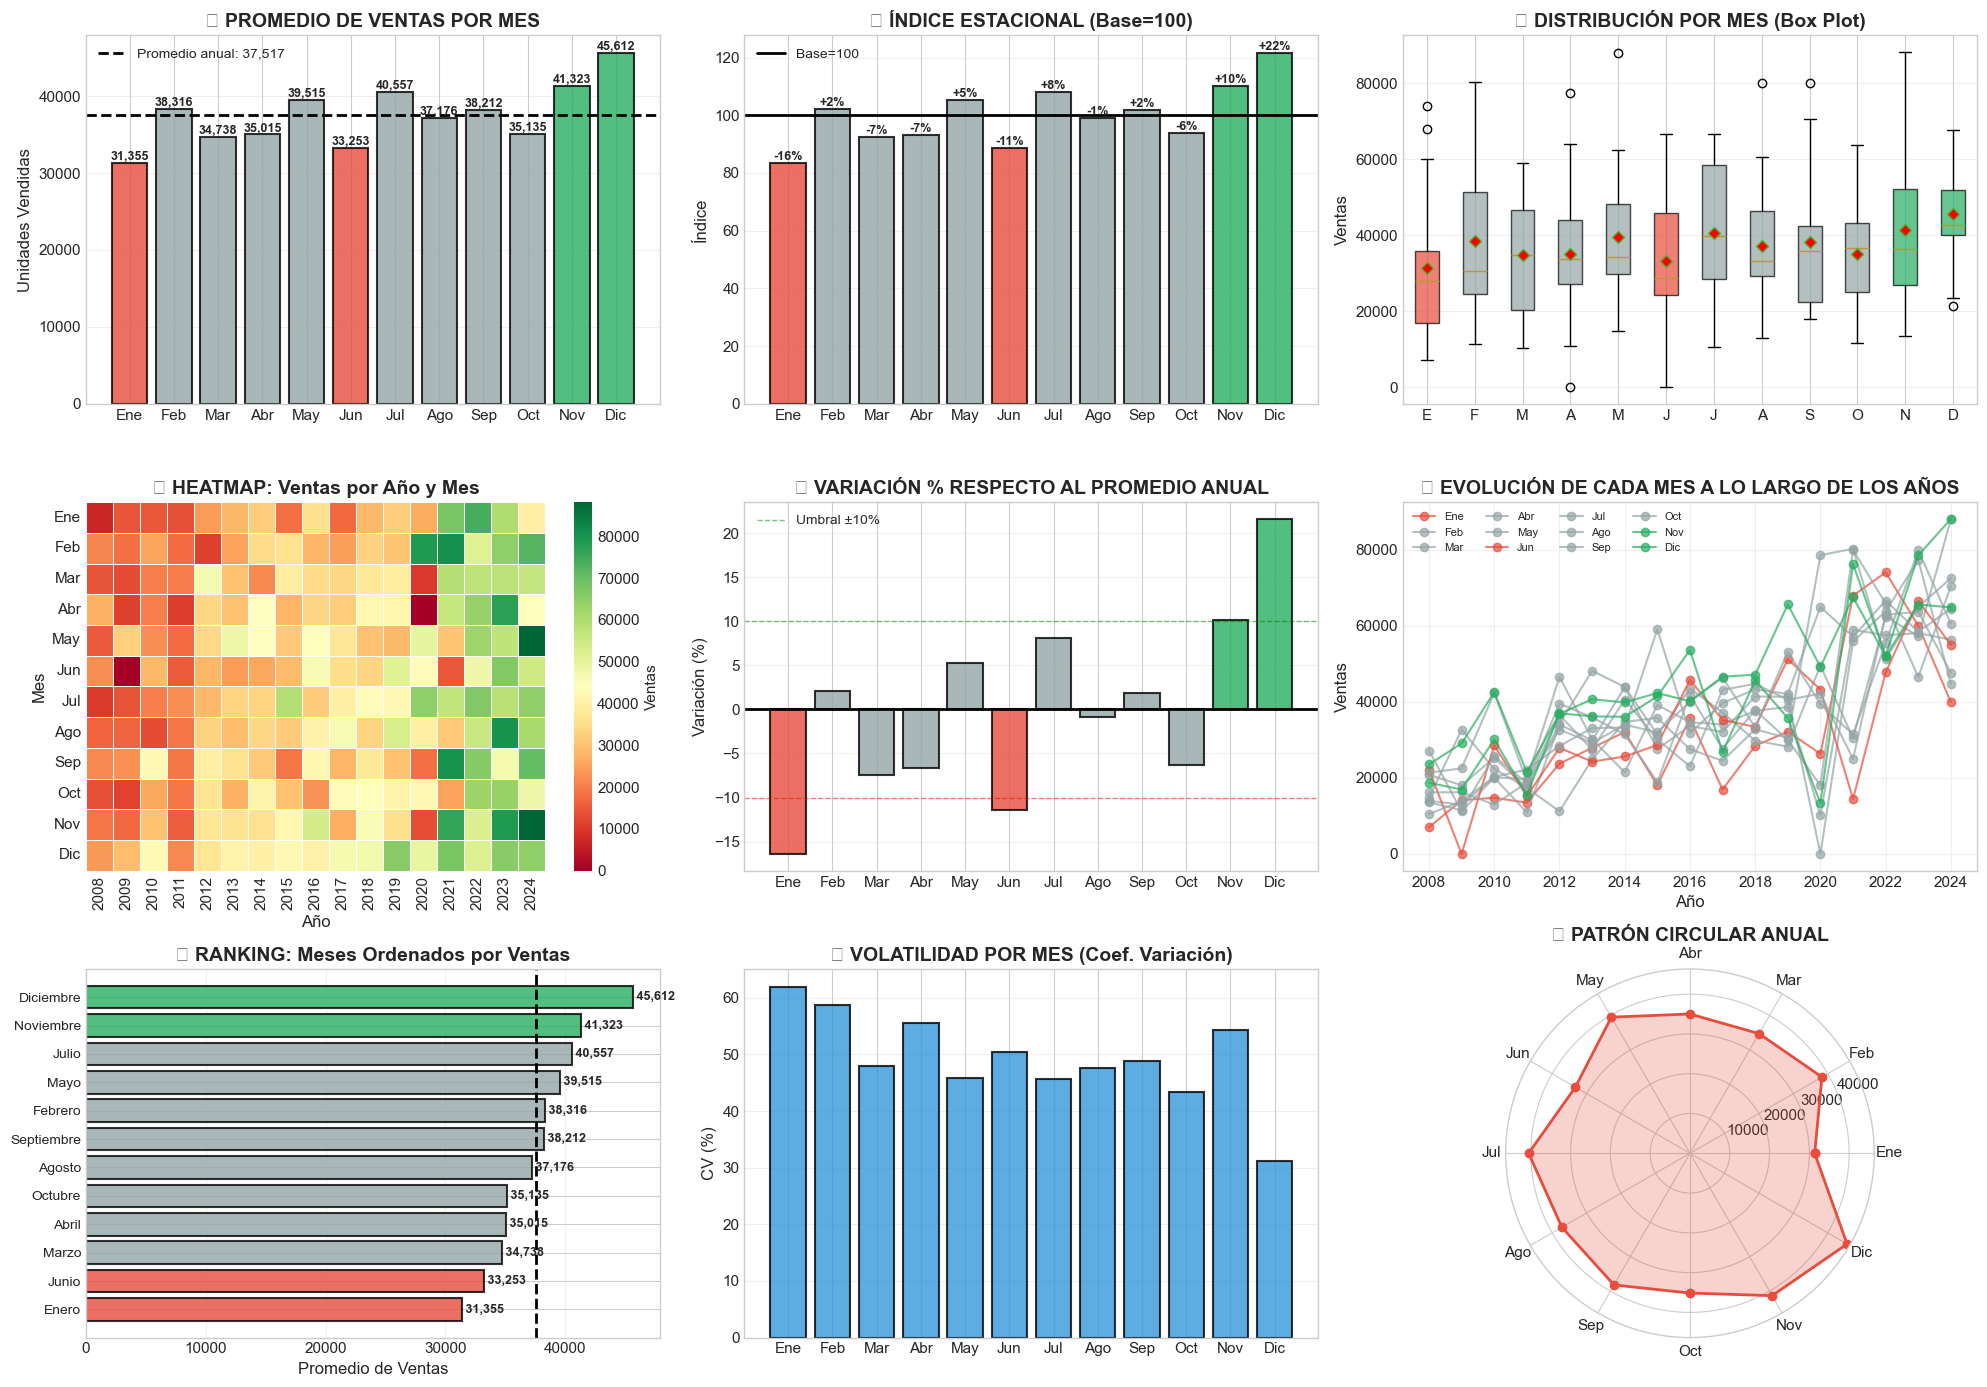


✓ Gráfico guardado en: /Users/DELL/datasets\patron_ventas_mensual_detallado.png
✓ Tabla guardada en: /Users/DELL/datasets\resumen_ventas_por_mes.csv

ANÁLISIS COMPLETADO ✓


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['font.size'] = 11

# ==========================================
# CARGA DE DATOS
# ==========================================

mainpath = "/Users/DELL/datasets"
filename = "VEN.csv"
FILE = os.path.join(mainpath, filename)

df = pd.read_csv(FILE)
df['FECHA'] = pd.to_datetime(df['AÑO'].astype(str) + '-' + df['MES'].astype(str) + '-01')
df_ventas = df[df['CONCEPTO'] == 'FACTURA VTA'].copy()

# Agregar por mes
serie_mensual = df_ventas.groupby('FECHA')['UNIDADES'].sum().sort_index()
date_range = pd.date_range(start=serie_mensual.index.min(), end=serie_mensual.index.max(), freq='MS')
ts_df = pd.DataFrame({'VENTAS': serie_mensual}).reindex(date_range, fill_value=0)

# Agregar columnas temporales
ts_df['AÑO'] = ts_df.index.year
ts_df['MES'] = ts_df.index.month
ts_df['MES_NOMBRE'] = ts_df.index.strftime('%b')

print("="*80)
print("ANÁLISIS DE PATRÓN DE VENTAS POR MES")
print("="*80)
print(f"\nPeriodo analizado: {ts_df.index.min().strftime('%Y-%m')} a {ts_df.index.max().strftime('%Y-%m')}")
print(f"Total de meses: {len(ts_df)}")
print(f"Total años completos: {ts_df['AÑO'].nunique()}")

# ==========================================
# ANÁLISIS POR MES
# ==========================================

# Estadísticas por mes
stats_por_mes = ts_df.groupby('MES')['VENTAS'].agg([
    ('Promedio', 'mean'),
    ('Mediana', 'median'),
    ('Total', 'sum'),
    ('Desv_Std', 'std'),
    ('Minimo', 'min'),
    ('Maximo', 'max')
]).round(0)

meses_nombres = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
                 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
stats_por_mes.index = meses_nombres

# Índice estacional
media_global = ts_df['VENTAS'].mean()
stats_por_mes['Índice_Estacional'] = ((stats_por_mes['Promedio'] / media_global) * 100).round(1)
stats_por_mes['Variación_%'] = ((stats_por_mes['Promedio'] / media_global - 1) * 100).round(1)

print("\n" + "="*80)
print("ESTADÍSTICAS DE VENTAS POR MES DEL AÑO")
print("="*80)
print(stats_por_mes.to_string())

# Identificar meses extremos
mes_max_idx = stats_por_mes['Promedio'].idxmax()
mes_min_idx = stats_por_mes['Promedio'].idxmin()
ventas_max = stats_por_mes.loc[mes_max_idx, 'Promedio']
ventas_min = stats_por_mes.loc[mes_min_idx, 'Promedio']
diferencia_abs = ventas_max - ventas_min
diferencia_pct = ((ventas_max / ventas_min - 1) * 100)

print("\n" + "="*80)
print("MESES CON MAYOR Y MENOR DEMANDA")
print("="*80)
print(f"\n🔴 MES CON MAYORES VENTAS: {mes_max_idx.upper()}")
print(f"   Promedio: {ventas_max:,.0f} unidades")
print(f"   Índice estacional: {stats_por_mes.loc[mes_max_idx, 'Índice_Estacional']:.1f}")
print(f"   → {stats_por_mes.loc[mes_max_idx, 'Variación_%']:+.1f}% respecto al promedio anual")

print(f"\n🟢 MES CON MENORES VENTAS: {mes_min_idx.upper()}")
print(f"   Promedio: {ventas_min:,.0f} unidades")
print(f"   Índice estacional: {stats_por_mes.loc[mes_min_idx, 'Índice_Estacional']:.1f}")
print(f"   → {stats_por_mes.loc[mes_min_idx, 'Variación_%']:+.1f}% respecto al promedio anual")

print(f"\n📊 DIFERENCIA ENTRE PICOS:")
print(f"   Absoluta: {diferencia_abs:,.0f} unidades")
print(f"   Relativa: {diferencia_pct:.1f}% más ventas en {mes_max_idx} vs {mes_min_idx}")

# Clasificar meses
print("\n" + "="*80)
print("CLASIFICACIÓN DE MESES POR DEMANDA")
print("="*80)

meses_altos = stats_por_mes[stats_por_mes['Variación_%'] > 10].index.tolist()
meses_bajos = stats_por_mes[stats_por_mes['Variación_%'] < -10].index.tolist()
meses_normales = stats_por_mes[
    (stats_por_mes['Variación_%'] >= -10) & 
    (stats_por_mes['Variación_%'] <= 10)
].index.tolist()

print(f"\n🔴 DEMANDA ALTA (>10% sobre promedio): {len(meses_altos)} meses")
for mes in meses_altos:
    print(f"   • {mes}: {stats_por_mes.loc[mes, 'Promedio']:,.0f} unidades ({stats_por_mes.loc[mes, 'Variación_%']:+.1f}%)")

print(f"\n⚪ DEMANDA NORMAL (±10% del promedio): {len(meses_normales)} meses")
for mes in meses_normales:
    print(f"   • {mes}: {stats_por_mes.loc[mes, 'Promedio']:,.0f} unidades ({stats_por_mes.loc[mes, 'Variación_%']:+.1f}%)")

print(f"\n🟢 DEMANDA BAJA (<-10% bajo promedio): {len(meses_bajos)} meses")
for mes in meses_bajos:
    print(f"   • {mes}: {stats_por_mes.loc[mes, 'Promedio']:,.0f} unidades ({stats_por_mes.loc[mes, 'Variación_%']:+.1f}%)")

# ==========================================
# VISUALIZACIONES
# ==========================================

fig = plt.figure(figsize=(20, 14))

# Colores según clasificación
def get_color(variacion):
    if variacion > 10:
        return '#27AE60'  # Verde (alta demanda)
    elif variacion < -10:
        return '#E74C3C'  # Rojo (baja demanda)
    else:
        return '#95A5A6'  # Gris (normal)

colores = [get_color(var) for var in stats_por_mes['Variación_%']]

# 1. PROMEDIO DE VENTAS POR MES (Gráfico principal)
ax1 = plt.subplot(3, 3, 1)
bars = ax1.bar(range(12), stats_por_mes['Promedio'], color=colores, 
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(y=media_global, color='black', linestyle='--', linewidth=2, 
            label=f'Promedio anual: {media_global:,.0f}')
ax1.set_xticks(range(12))
ax1.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
ax1.set_title('📊 PROMEDIO DE VENTAS POR MES', fontweight='bold', fontsize=14)
ax1.set_ylabel('Unidades Vendidas', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Agregar valores sobre las barras
for i, (bar, val) in enumerate(zip(bars, stats_por_mes['Promedio'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(val):,}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. ÍNDICE ESTACIONAL
ax2 = plt.subplot(3, 3, 2)
bars2 = ax2.bar(range(12), stats_por_mes['Índice_Estacional'], color=colores, 
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=100, color='black', linestyle='-', linewidth=2, label='Base=100')
ax2.set_xticks(range(12))
ax2.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
ax2.set_title('📈 ÍNDICE ESTACIONAL (Base=100)', fontweight='bold', fontsize=14)
ax2.set_ylabel('Índice', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Agregar porcentajes
for bar, val in zip(bars2, stats_por_mes['Variación_%']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:+.0f}%',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. DISTRIBUCIÓN POR MES (Box plot detallado)
ax3 = plt.subplot(3, 3, 3)
monthly_data = [ts_df[ts_df['MES'] == mes]['VENTAS'].values for mes in range(1, 13)]
bp = ax3.boxplot(monthly_data, labels=['E', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'],
                 patch_artist=True, showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=6))
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colores[i])
    patch.set_alpha(0.7)
ax3.set_title('📦 DISTRIBUCIÓN POR MES (Box Plot)', fontweight='bold', fontsize=14)
ax3.set_ylabel('Ventas', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# 4. EVOLUCIÓN POR AÑO Y MES (Heatmap)
ax4 = plt.subplot(3, 3, 4)
pivot_ventas = ts_df.pivot_table(values='VENTAS', index='MES', columns='AÑO', aggfunc='mean')
sns.heatmap(pivot_ventas, annot=False, fmt='.0f', cmap='RdYlGn', 
            ax=ax4, cbar_kws={'label': 'Ventas'}, linewidths=0.5)
ax4.set_yticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
ax4.set_title('🔥 HEATMAP: Ventas por Año y Mes', fontweight='bold', fontsize=14)
ax4.set_xlabel('Año', fontsize=12)
ax4.set_ylabel('Mes', fontsize=12)

# 5. VARIACIÓN PORCENTUAL
ax5 = plt.subplot(3, 3, 5)
bars5 = ax5.bar(range(12), stats_por_mes['Variación_%'], color=colores, 
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax5.axhline(y=10, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Umbral ±10%')
ax5.axhline(y=-10, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax5.set_xticks(range(12))
ax5.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
ax5.set_title('📊 VARIACIÓN % RESPECTO AL PROMEDIO ANUAL', fontweight='bold', fontsize=14)
ax5.set_ylabel('Variación (%)', fontsize=12)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# 6. LÍNEA DE TENDENCIA POR MES A LO LARGO DE LOS AÑOS
ax6 = plt.subplot(3, 3, 6)
for mes in range(1, 13):
    datos_mes = ts_df[ts_df['MES'] == mes].sort_values('AÑO')
    color = colores[mes-1]
    ax6.plot(datos_mes['AÑO'], datos_mes['VENTAS'], marker='o', 
             label=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'][mes-1],
             alpha=0.7, linewidth=1.5, color=color)
ax6.set_title('📈 EVOLUCIÓN DE CADA MES A LO LARGO DE LOS AÑOS', fontweight='bold', fontsize=14)
ax6.set_xlabel('Año', fontsize=12)
ax6.set_ylabel('Ventas', fontsize=12)
ax6.legend(ncol=4, fontsize=8, loc='upper left')
ax6.grid(True, alpha=0.3)

# 7. RANKING DE MESES
ax7 = plt.subplot(3, 3, 7)
ranking = stats_por_mes.sort_values('Promedio', ascending=True)
colors_ranking = [get_color(var) for var in ranking['Variación_%']]
bars7 = ax7.barh(range(12), ranking['Promedio'], color=colors_ranking, 
                 alpha=0.8, edgecolor='black', linewidth=1.5)
ax7.set_yticks(range(12))
ax7.set_yticklabels(ranking.index, fontsize=10)
ax7.axvline(x=media_global, color='black', linestyle='--', linewidth=2)
ax7.set_title('🏆 RANKING: Meses Ordenados por Ventas', fontweight='bold', fontsize=14)
ax7.set_xlabel('Promedio de Ventas', fontsize=12)
ax7.grid(True, alpha=0.3, axis='x')

# Agregar valores
for i, (bar, val) in enumerate(zip(bars7, ranking['Promedio'])):
    width = bar.get_width()
    ax7.text(width, bar.get_y() + bar.get_height()/2.,
             f' {int(val):,}',
             ha='left', va='center', fontsize=9, fontweight='bold')

# 8. VOLATILIDAD POR MES
ax8 = plt.subplot(3, 3, 8)
coef_var = (stats_por_mes['Desv_Std'] / stats_por_mes['Promedio'] * 100).round(1)
bars8 = ax8.bar(range(12), coef_var, color='#3498DB', 
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax8.set_xticks(range(12))
ax8.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
ax8.set_title('📊 VOLATILIDAD POR MES (Coef. Variación)', fontweight='bold', fontsize=14)
ax8.set_ylabel('CV (%)', fontsize=12)
ax8.grid(True, alpha=0.3, axis='y')

# 9. RADAR CHART (Patrón circular anual)
ax9 = plt.subplot(3, 3, 9, projection='polar')
angles = np.linspace(0, 2 * np.pi, 12, endpoint=False).tolist()
valores = stats_por_mes['Promedio'].tolist()
valores += valores[:1]  # Cerrar el círculo
angles += angles[:1]

ax9.plot(angles, valores, 'o-', linewidth=2, color='#E74C3C')
ax9.fill(angles, valores, alpha=0.25, color='#E74C3C')
ax9.set_xticks(angles[:-1])
ax9.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
ax9.set_title('🔄 PATRÓN CIRCULAR ANUAL', fontweight='bold', fontsize=14, pad=20)
ax9.grid(True)

plt.tight_layout()
output_file = os.path.join(mainpath, 'patron_ventas_mensual_detallado.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado en: {output_file}")

# ==========================================
# GUARDAR TABLA RESUMEN
# ==========================================

stats_por_mes.to_csv(os.path.join(mainpath, 'resumen_ventas_por_mes.csv'))
print(f"✓ Tabla guardada en: {os.path.join(mainpath, 'resumen_ventas_por_mes.csv')}")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO ✓")
print("="*80)

In [ ]:
 ## Box jenkis sin  los 5 outliers altos y bajos 

BOX-JENKINS (ARIMA) - ANÁLISIS SIN OUTLIERS EXTREMOS

Datos originales:
  Periodo: 2008-01 a 2024-12
  Total observaciones: 204
  Media: 37777.85
  Desv. Std: 18010.12

PASO 1: IDENTIFICACIÓN Y ELIMINACIÓN DE OUTLIERS

🔴 TOP 5 OUTLIERS MÁS ALTOS (a eliminar):
   2024-11: 88,139 unidades
   2024-05: 88,012 unidades
   2021-02: 80,289 unidades
   2021-09: 80,020 unidades
   2023-08: 79,905 unidades

🟢 TOP 5 OUTLIERS MÁS BAJOS (a eliminar):
   2008-01: 7,034 unidades
   2020-03: 10,183 unidades
   2008-07: 10,501 unidades
   2011-04: 10,929 unidades
   2009-04: 11,219 unidades

📊 Serie limpia:
  Observaciones removidas: 10
  Observaciones válidas: 204
  Nueva media: 37465.95
  Nueva desv. std: 16378.46
  Cambio en media: -0.83%

PASO 2: PRUEBAS DE ESTACIONARIEDAD

📊 Serie Original (sin outliers):

   Test Augmented Dickey-Fuller (ADF):
      Estadístico: -0.9526
      p-value: 0.770145
      Lags usados: 9
      Valores críticos:
         1%: -3.4647
         5%: -2.8766
         10%: -2.

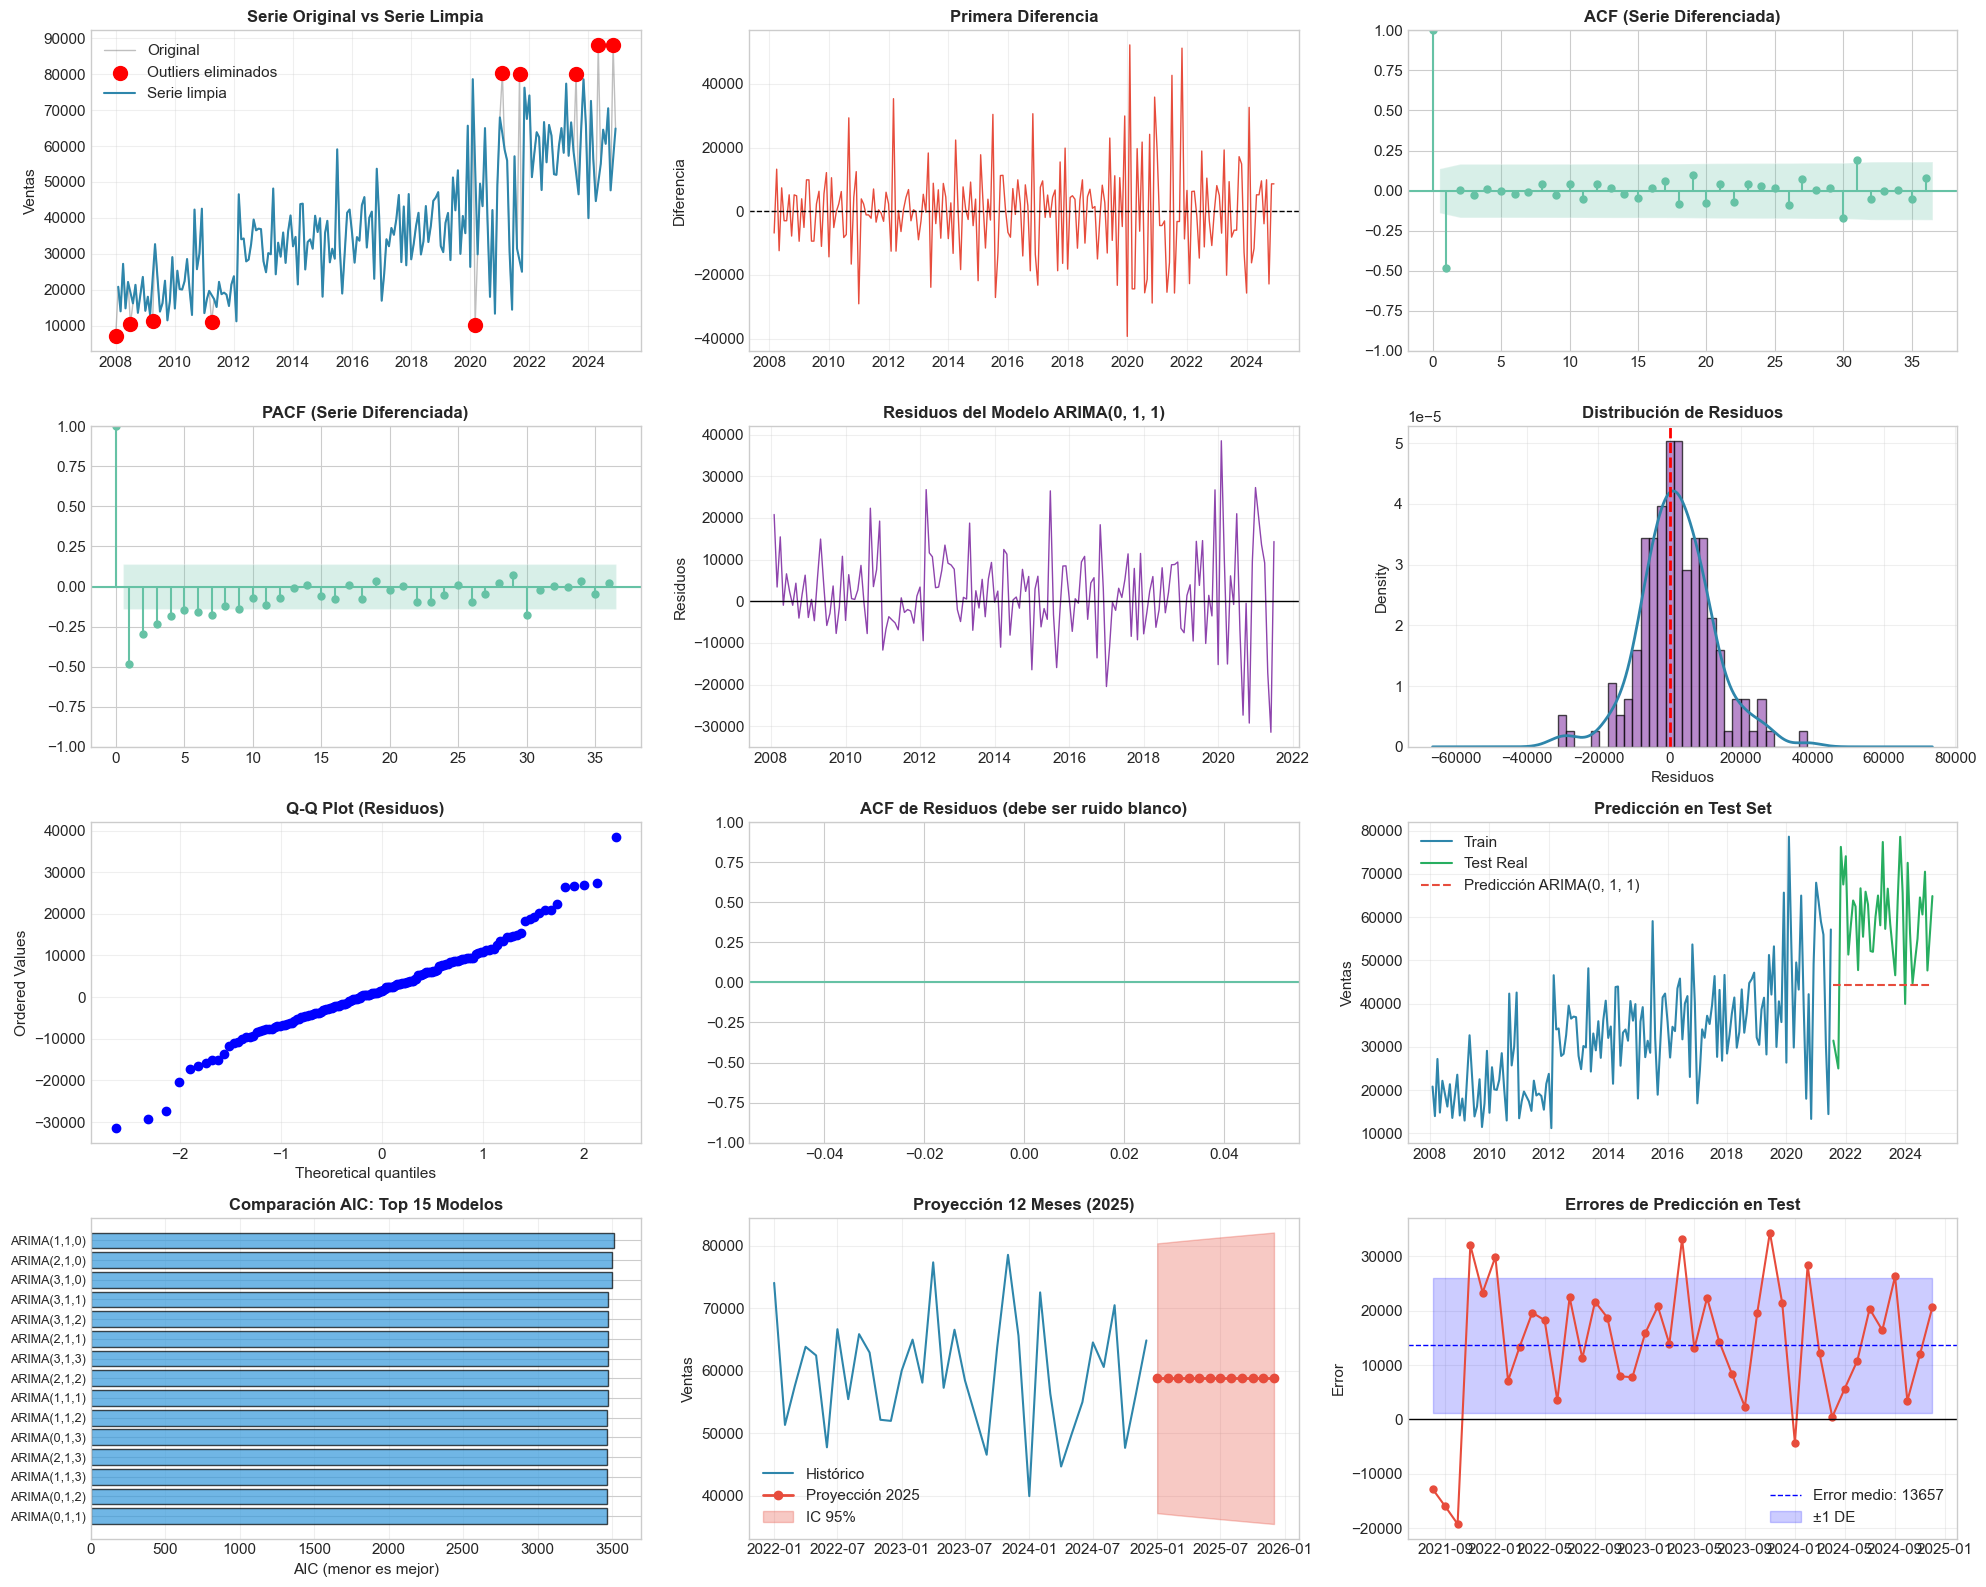


✓ Visualizaciones guardadas en: /Users/DELL/datasets\box_jenkins_arima_sin_outliers.png

✓ Resultados exportados:
   • /Users/DELL/datasets\serie_limpia_sin_outliers.csv
   • /Users/DELL/datasets\proyeccion_2025_arima.csv
   • /Users/DELL/datasets\metricas_modelo_arima.csv

BOX-JENKINS COMPLETADO ✓


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Librerías para Box-Jenkins/ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (20, 14)

# ==========================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ==========================================

mainpath = "/Users/DELL/datasets"
filename = "VEN.csv"
FILE = os.path.join(mainpath, filename)

df = pd.read_csv(FILE)
df['FECHA'] = pd.to_datetime(df['AÑO'].astype(str) + '-' + df['MES'].astype(str) + '-01')
df_ventas = df[df['CONCEPTO'] == 'FACTURA VTA'].copy()

serie_mensual = df_ventas.groupby('FECHA')['UNIDADES'].sum().sort_index()
date_range = pd.date_range(start=serie_mensual.index.min(), end=serie_mensual.index.max(), freq='MS')
ts_df = pd.DataFrame({'VENTAS': serie_mensual}).reindex(date_range, fill_value=0)

# Reemplazar ceros con interpolación lineal
ts_df['VENTAS'] = ts_df['VENTAS'].replace(0, np.nan).interpolate(method='linear')

print("="*80)
print("BOX-JENKINS (ARIMA) - ANÁLISIS SIN OUTLIERS EXTREMOS")
print("="*80)
print(f"\nDatos originales:")
print(f"  Periodo: {ts_df.index.min().strftime('%Y-%m')} a {ts_df.index.max().strftime('%Y-%m')}")
print(f"  Total observaciones: {len(ts_df)}")
print(f"  Media: {ts_df['VENTAS'].mean():.2f}")
print(f"  Desv. Std: {ts_df['VENTAS'].std():.2f}")

# ==========================================
# 2. IDENTIFICACIÓN Y ELIMINACIÓN DE OUTLIERS
# ==========================================

print("\n" + "="*80)
print("PASO 1: IDENTIFICACIÓN Y ELIMINACIÓN DE OUTLIERS")
print("="*80)

# Identificar los 5 más altos y 5 más bajos
n_outliers = 5
outliers_altos = ts_df.nlargest(n_outliers, 'VENTAS')
outliers_bajos = ts_df.nsmallest(n_outliers, 'VENTAS')

print(f"\n🔴 TOP {n_outliers} OUTLIERS MÁS ALTOS (a eliminar):")
for idx, row in outliers_altos.iterrows():
    print(f"   {idx.strftime('%Y-%m')}: {row['VENTAS']:,.0f} unidades")

print(f"\n🟢 TOP {n_outliers} OUTLIERS MÁS BAJOS (a eliminar):")
for idx, row in outliers_bajos.iterrows():
    print(f"   {idx.strftime('%Y-%m')}: {row['VENTAS']:,.0f} unidades")

# Crear serie sin outliers (interpolación lineal)
ts_limpia = ts_df.copy()
outliers_indices = outliers_altos.index.union(outliers_bajos.index)
ts_limpia.loc[outliers_indices, 'VENTAS'] = np.nan
ts_limpia['VENTAS'] = ts_limpia['VENTAS'].interpolate(method='linear')

print(f"\n📊 Serie limpia:")
print(f"  Observaciones removidas: {len(outliers_indices)}")
print(f"  Observaciones válidas: {len(ts_limpia)}")
print(f"  Nueva media: {ts_limpia['VENTAS'].mean():.2f}")
print(f"  Nueva desv. std: {ts_limpia['VENTAS'].std():.2f}")
print(f"  Cambio en media: {((ts_limpia['VENTAS'].mean()/ts_df['VENTAS'].mean())-1)*100:+.2f}%")

# ==========================================
# 3. PRUEBAS DE ESTACIONARIEDAD
# ==========================================

print("\n" + "="*80)
print("PASO 2: PRUEBAS DE ESTACIONARIEDAD")
print("="*80)

def pruebas_estacionariedad(serie, nombre="Serie"):
    """Realiza pruebas ADF y KPSS"""
    print(f"\n📊 {nombre}:")
    
    # Augmented Dickey-Fuller
    adf_result = adfuller(serie.dropna(), autolag='AIC')
    print(f"\n   Test Augmented Dickey-Fuller (ADF):")
    print(f"      Estadístico: {adf_result[0]:.4f}")
    print(f"      p-value: {adf_result[1]:.6f}")
    print(f"      Lags usados: {adf_result[2]}")
    print(f"      Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"         {key}: {value:.4f}")
    if adf_result[1] < 0.05:
        print(f"      ✓ ESTACIONARIA (rechazamos H0: tiene raíz unitaria)")
    else:
        print(f"      ✗ NO ESTACIONARIA (no rechazamos H0)")
    
    # KPSS Test
    kpss_result = kpss(serie.dropna(), regression='ct', nlags='auto')
    print(f"\n   Test KPSS:")
    print(f"      Estadístico: {kpss_result[0]:.4f}")
    print(f"      p-value: {kpss_result[1]:.6f}")
    print(f"      Lags usados: {kpss_result[2]}")
    print(f"      Valores críticos:")
    for key, value in kpss_result[3].items():
        print(f"         {key}: {value:.4f}")
    if kpss_result[1] > 0.05:
        print(f"      ✓ ESTACIONARIA (no rechazamos H0: es estacionaria)")
    else:
        print(f"      ✗ NO ESTACIONARIA (rechazamos H0)")
    
    return adf_result, kpss_result

# Pruebas en serie limpia
adf_original, kpss_original = pruebas_estacionariedad(ts_limpia['VENTAS'], "Serie Original (sin outliers)")

# Primera diferencia
ts_limpia['DIFF1'] = ts_limpia['VENTAS'].diff()
adf_diff1, kpss_diff1 = pruebas_estacionariedad(ts_limpia['DIFF1'].dropna(), "Primera Diferencia")

# Diferencia estacional (lag 12)
ts_limpia['DIFF_ESTACIONAL'] = ts_limpia['VENTAS'].diff(12)
adf_diff12, kpss_diff12 = pruebas_estacionariedad(ts_limpia['DIFF_ESTACIONAL'].dropna(), "Diferencia Estacional (lag 12)")

# ==========================================
# 4. ANÁLISIS ACF Y PACF
# ==========================================

print("\n" + "="*80)
print("PASO 3: IDENTIFICACIÓN DEL MODELO (ACF/PACF)")
print("="*80)

# Determinar orden de diferenciación necesario
d = 0 if adf_original[1] < 0.05 else 1
D = 0  # Diferenciación estacional (ajustar si necesario)

print(f"\n📊 Orden de diferenciación sugerido:")
print(f"   d (no estacional): {d}")
print(f"   D (estacional): {D}")

# Serie a usar para ACF/PACF
if d == 1:
    serie_analisis = ts_limpia['DIFF1'].dropna()
    print(f"\n   → Analizando PRIMERA DIFERENCIA")
else:
    serie_analisis = ts_limpia['VENTAS'].dropna()
    print(f"\n   → Analizando SERIE ORIGINAL")

# Calcular ACF y PACF
acf_values = acf(serie_analisis, nlags=36)
pacf_values = pacf(serie_analisis, nlags=36, method='ywm')

# Identificar lags significativos
umbral = 1.96 / np.sqrt(len(serie_analisis))
print(f"\n📊 Lags significativos en ACF:")
for i in range(1, min(13, len(acf_values))):
    if abs(acf_values[i]) > umbral:
        print(f"   Lag {i}: {acf_values[i]:.3f} {'✓' if abs(acf_values[i]) > 0.2 else ''}")

print(f"\n📊 Lags significativos en PACF:")
for i in range(1, min(13, len(pacf_values))):
    if abs(pacf_values[i]) > umbral:
        print(f"   Lag {i}: {pacf_values[i]:.3f} {'✓' if abs(pacf_values[i]) > 0.2 else ''}")

# Sugerencias de órdenes p, q
print(f"\n💡 SUGERENCIAS INICIALES:")
print(f"   • Si PACF corta en lag k → AR(k) → p=k")
print(f"   • Si ACF corta en lag k → MA(k) → q=k")
print(f"   • Si ambos decaen gradualmente → ARMA(p,q)")

# ==========================================
# 5. BÚSQUEDA DEL MEJOR MODELO ARIMA
# ==========================================

print("\n" + "="*80)
print("PASO 4: BÚSQUEDA AUTOMÁTICA DEL MEJOR MODELO")
print("="*80)

# Dividir en train/test (80/20)
train_size = int(len(ts_limpia) * 0.8)
train_data = ts_limpia['VENTAS'][:train_size]
test_data = ts_limpia['VENTAS'][train_size:]

print(f"\nDivisión de datos:")
print(f"  Train: {len(train_data)} observaciones ({ts_limpia.index[0].strftime('%Y-%m')} a {ts_limpia.index[train_size-1].strftime('%Y-%m')})")
print(f"  Test: {len(test_data)} observaciones ({ts_limpia.index[train_size].strftime('%Y-%m')} a {ts_limpia.index[-1].strftime('%Y-%m')})")

# Grid search para encontrar mejor modelo
print(f"\n🔍 Buscando mejor combinación (p,d,q)...")
print(f"   Rango p: [0, 1, 2, 3]")
print(f"   Rango d: [{d}]")
print(f"   Rango q: [0, 1, 2, 3]")

p_range = range(0, 4)
d_range = [d]
q_range = range(0, 4)

best_aic = np.inf
best_bic = np.inf
best_order = None
resultados_modelos = []

for p, d_val, q in itertools.product(p_range, d_range, q_range):
    try:
        model = ARIMA(train_data, order=(p, d_val, q))
        fitted_model = model.fit()
        
        aic = fitted_model.aic
        bic = fitted_model.bic
        
        resultados_modelos.append({
            'Orden': f'ARIMA({p},{d_val},{q})',
            'p': p, 'd': d_val, 'q': q,
            'AIC': aic,
            'BIC': bic,
            'Params': fitted_model.params.shape[0]
        })
        
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d_val, q)
            best_model = fitted_model
            
    except:
        continue

# Mostrar top 10 modelos
df_resultados = pd.DataFrame(resultados_modelos).sort_values('AIC')
print(f"\n📊 TOP 10 MODELOS POR AIC:")
print(df_resultados.head(10).to_string(index=False))

print(f"\n✓ MEJOR MODELO SELECCIONADO: ARIMA{best_order}")
print(f"   AIC: {best_aic:.2f}")

# Obtener BIC del mejor modelo
best_bic_value = df_resultados[(df_resultados['p']==best_order[0]) & 
                                (df_resultados['d']==best_order[1]) & 
                                (df_resultados['q']==best_order[2])]['BIC'].values[0]
print(f"   BIC: {best_bic_value:.2f}")

# ==========================================
# 6. AJUSTE DEL MODELO FINAL
# ==========================================

print("\n" + "="*80)
print("PASO 5: AJUSTE Y DIAGNÓSTICO DEL MODELO FINAL")
print("="*80)

# Reajustar con toda la data de entrenamiento
final_model = ARIMA(train_data, order=best_order).fit()

print(f"\n📊 RESUMEN DEL MODELO:")
print(final_model.summary())

# ==========================================
# 7. DIAGNÓSTICO DE RESIDUOS
# ==========================================

print("\n" + "="*80)
print("PASO 6: DIAGNÓSTICO DE RESIDUOS")
print("="*80)

residuos = final_model.resid

# Estadísticas de residuos
print(f"\n📊 Estadísticas de residuos:")
print(f"   Media: {residuos.mean():.4f} (debe estar cerca de 0)")
print(f"   Desv. Std: {residuos.std():.2f}")
print(f"   Asimetría: {residuos.skew():.4f}")
print(f"   Curtosis: {residuos.kurtosis():.4f}")

# Prueba de normalidad
_, p_shapiro = stats.shapiro(residuos)
print(f"\n   Test Shapiro-Wilk (normalidad):")
print(f"      p-value: {p_shapiro:.6f}")
print(f"      {'✓ Residuos normales' if p_shapiro > 0.05 else '✗ Residuos NO normales'}")

# Prueba Ljung-Box (autocorrelación de residuos)
lb_test = acorr_ljungbox(residuos, lags=[10, 15, 20], return_df=True)
print(f"\n   Test Ljung-Box (autocorrelación de residuos):")
print(lb_test)
print(f"      {'✓ Residuos NO autocorrelacionados (ruido blanco)' if lb_test['lb_pvalue'].iloc[0] > 0.05 else '✗ Residuos autocorrelacionados'}")

# ==========================================
# 8. EVALUACIÓN EN TEST SET
# ==========================================

print("\n" + "="*80)
print("PASO 7: EVALUACIÓN EN TEST SET")
print("="*80)

# Predicciones
forecast_steps = len(test_data)
forecast = final_model.forecast(steps=forecast_steps)

# Métricas
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)
mape = mean_absolute_percentage_error(test_data, forecast) * 100

print(f"\n📊 MÉTRICAS DE DESEMPEÑO:")
print(f"   RMSE: {rmse:.2f}")
print(f"   MAE: {mae:.2f}")
print(f"   MAPE: {mape:.2f}%")

# Comparación con modelo naive (benchmark)
naive_forecast = train_data.iloc[-1]
rmse_naive = np.sqrt(mean_squared_error(test_data, [naive_forecast]*len(test_data)))
print(f"\n   Benchmark (Naive - último valor):")
print(f"      RMSE Naive: {rmse_naive:.2f}")
print(f"      Mejora: {((rmse_naive - rmse)/rmse_naive)*100:.2f}%")

# ==========================================
# 9. PROYECCIÓN FUTURA
# ==========================================

print("\n" + "="*80)
print("PASO 8: PROYECCIÓN FUTURA (12 MESES)")
print("="*80)

# Reajustar con TODA la data limpia
modelo_completo = ARIMA(ts_limpia['VENTAS'], order=best_order).fit()
proyeccion = modelo_completo.forecast(steps=12)
proyeccion_conf = modelo_completo.get_forecast(steps=12).conf_int()

print(f"\n📈 PROYECCIÓN 2025:")
fechas_futuras = pd.date_range(start=ts_limpia.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
for fecha, valor, (lower, upper) in zip(fechas_futuras, proyeccion, proyeccion_conf.values):
    print(f"   {fecha.strftime('%Y-%m')}: {valor:,.0f} unidades [IC 95%: {lower:,.0f} - {upper:,.0f}]")

# ==========================================
# 10. VISUALIZACIONES
# ==========================================

fig = plt.figure(figsize=(20, 16))

# 10.1 Serie original vs limpia
ax1 = plt.subplot(4, 3, 1)
ax1.plot(ts_df.index, ts_df['VENTAS'], linewidth=1, alpha=0.5, color='gray', label='Original')
ax1.scatter(outliers_indices, ts_df.loc[outliers_indices, 'VENTAS'], 
            color='red', s=100, zorder=5, label='Outliers eliminados')
ax1.plot(ts_limpia.index, ts_limpia['VENTAS'], linewidth=1.5, color='#2E86AB', label='Serie limpia')
ax1.set_title('Serie Original vs Serie Limpia', fontweight='bold', fontsize=12)
ax1.set_ylabel('Ventas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 10.2 Primera diferencia
ax2 = plt.subplot(4, 3, 2)
ax2.plot(ts_limpia.index[1:], ts_limpia['DIFF1'][1:], linewidth=1, color='#E74C3C')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_title('Primera Diferencia', fontweight='bold', fontsize=12)
ax2.set_ylabel('Diferencia')
ax2.grid(True, alpha=0.3)

# 10.3 ACF
ax3 = plt.subplot(4, 3, 3)
plot_acf(serie_analisis, lags=36, ax=ax3, alpha=0.05)
ax3.set_title('ACF (Serie Diferenciada)', fontweight='bold', fontsize=12)

# 10.4 PACF
ax4 = plt.subplot(4, 3, 4)
plot_pacf(serie_analisis, lags=36, ax=ax4, alpha=0.05, method='ywm')
ax4.set_title('PACF (Serie Diferenciada)', fontweight='bold', fontsize=12)

# 10.5 Residuos
ax5 = plt.subplot(4, 3, 5)
ax5.plot(residuos.index, residuos, linewidth=1, color='#8E44AD')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.set_title(f'Residuos del Modelo ARIMA{best_order}', fontweight='bold', fontsize=12)
ax5.set_ylabel('Residuos')
ax5.grid(True, alpha=0.3)

# 10.6 Histograma de residuos
ax6 = plt.subplot(4, 3, 6)
ax6.hist(residuos, bins=30, density=True, alpha=0.7, color='#9B59B6', edgecolor='black')
residuos.plot(kind='kde', ax=ax6, color='#2E86AB', linewidth=2)
ax6.axvline(0, color='red', linestyle='--', linewidth=2)
ax6.set_title('Distribución de Residuos', fontweight='bold', fontsize=12)
ax6.set_xlabel('Residuos')
ax6.grid(True, alpha=0.3)

# 10.7 Q-Q plot de residuos
ax7 = plt.subplot(4, 3, 7)
stats.probplot(residuos, dist="norm", plot=ax7)
ax7.set_title('Q-Q Plot (Residuos)', fontweight='bold', fontsize=12)
ax7.grid(True, alpha=0.3)

# 10.8 ACF de residuos
ax8 = plt.subplot(4, 3, 8)
plot_acf(residuos, lags=24, ax=ax8, alpha=0.05)
ax8.set_title('ACF de Residuos (debe ser ruido blanco)', fontweight='bold', fontsize=12)

# 10.9 Train vs Predicción en Test
ax9 = plt.subplot(4, 3, 9)
ax9.plot(train_data.index, train_data, linewidth=1.5, color='#2E86AB', label='Train')
ax9.plot(test_data.index, test_data, linewidth=1.5, color='#27AE60', label='Test Real')
ax9.plot(test_data.index, forecast, linewidth=1.5, color='#E74C3C', 
         linestyle='--', label=f'Predicción ARIMA{best_order}')
ax9.set_title('Predicción en Test Set', fontweight='bold', fontsize=12)
ax9.set_ylabel('Ventas')
ax9.legend()
ax9.grid(True, alpha=0.3)

# 10.10 Comparación AIC de modelos
ax10 = plt.subplot(4, 3, 10)
top_models = df_resultados.head(15)
ax10.barh(range(len(top_models)), top_models['AIC'], color='#3498DB', alpha=0.7, edgecolor='black')
ax10.set_yticks(range(len(top_models)))
ax10.set_yticklabels(top_models['Orden'], fontsize=9)
ax10.set_title('Comparación AIC: Top 15 Modelos', fontweight='bold', fontsize=12)
ax10.set_xlabel('AIC (menor es mejor)')
ax10.grid(True, alpha=0.3, axis='x')

# 10.11 Proyección futura
ax11 = plt.subplot(4, 3, 11)
ax11.plot(ts_limpia.index[-36:], ts_limpia['VENTAS'][-36:], 
          linewidth=1.5, color='#2E86AB', label='Histórico')
ax11.plot(fechas_futuras, proyeccion, linewidth=2, color='#E74C3C', 
          marker='o', markersize=6, label='Proyección 2025')
ax11.fill_between(fechas_futuras, proyeccion_conf.iloc[:, 0], proyeccion_conf.iloc[:, 1],
                  alpha=0.3, color='#E74C3C', label='IC 95%')
ax11.set_title('Proyección 12 Meses (2025)', fontweight='bold', fontsize=12)
ax11.set_ylabel('Ventas')
ax11.legend()
ax11.grid(True, alpha=0.3)

# 10.12 Errores de predicción
ax12 = plt.subplot(4, 3, 12)
errores = test_data - forecast
ax12.plot(test_data.index, errores, linewidth=1.5, color='#E74C3C', marker='o', markersize=5)
ax12.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax12.axhline(y=errores.mean(), color='blue', linestyle='--', linewidth=1, label=f'Error medio: {errores.mean():.0f}')
ax12.fill_between(test_data.index, errores.mean() - errores.std(), errores.mean() + errores.std(),
                  alpha=0.2, color='blue', label='±1 DE')
ax12.set_title('Errores de Predicción en Test', fontweight='bold', fontsize=12)
ax12.set_ylabel('Error')
ax12.legend()
ax12.grid(True, alpha=0.3)

plt.tight_layout()
output_file = os.path.join(mainpath, 'box_jenkins_arima_sin_outliers.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualizaciones guardadas en: {output_file}")

# ==========================================
# 11. GUARDAR RESULTADOS
# ==========================================

# Exportar serie limpia
ts_limpia.to_csv(os.path.join(mainpath, 'serie_limpia_sin_outliers.csv'))

# Exportar proyección
proyeccion_df = pd.DataFrame({
    'FECHA': fechas_futuras,
    'PROYECCION': proyeccion.values,
    'LIMITE_INFERIOR': proyeccion_conf.iloc[:, 0].values,
    'LIMITE_SUPERIOR': proyeccion_conf.iloc[:, 1].values
})
proyeccion_df.to_csv(os.path.join(mainpath, 'proyeccion_2025_arima.csv'), index=False)

# Exportar métricas
metricas_df = pd.DataFrame({
    'Modelo': [f'ARIMA{best_order}'],
    'AIC': [best_aic],
    'BIC': [best_bic_value],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
})
metricas_df.to_csv(os.path.join(mainpath, 'metricas_modelo_arima.csv'), index=False)

print(f"\n✓ Resultados exportados:")
print(f"   • {os.path.join(mainpath, 'serie_limpia_sin_outliers.csv')}")
print(f"   • {os.path.join(mainpath, 'proyeccion_2025_arima.csv')}")
print(f"   • {os.path.join(mainpath, 'metricas_modelo_arima.csv')}")

print("\n" + "="*80)
print("BOX-JENKINS COMPLETADO ✓")
print("="*80)

In [ ]:
## Arima sin ouli

MODELO ARIMA FINAL - IMPLEMENTACIÓN Y PRONÓSTICO

⚠️  Creando serie limpia (sin outliers)...

📊 DATOS:
   Periodo: 2008-01 a 2024-12
   Total observaciones: 204
   Media: 37465.95
   Desv. Std: 16378.46

CONFIGURACIÓN DEL MODELO ARIMA

📊 MODELO SELECCIONADO: ARIMA(2,1,2)

   Parámetros:
   • p (AR): 2 - Orden autorregresivo
   • d (I): 1 - Orden de diferenciación
   • q (MA): 2 - Orden de media móvil

📈 Test ADF en serie original:
   p-value: 0.770145
   ✗ No estacionaria (requiere diferenciación)

📈 Test ADF después de 1 diferencia(s):
   p-value: 0.000000
   ✓ Ahora es estacionaria

AJUSTE DEL MODELO ARIMA

📊 División de datos:
   Entrenamiento: 173 obs (2008-01 a 2022-05)
   Validación: 31 obs (2022-06 a 2024-12)

🔄 Ajustando modelo ARIMA(2,1,2)...
✓ Modelo ajustado exitosamente

RESUMEN DEL MODELO
                               SARIMAX Results                                
Dep. Variable:                 VENTAS   No. Observations:                  173
Model:                 ARIMA(

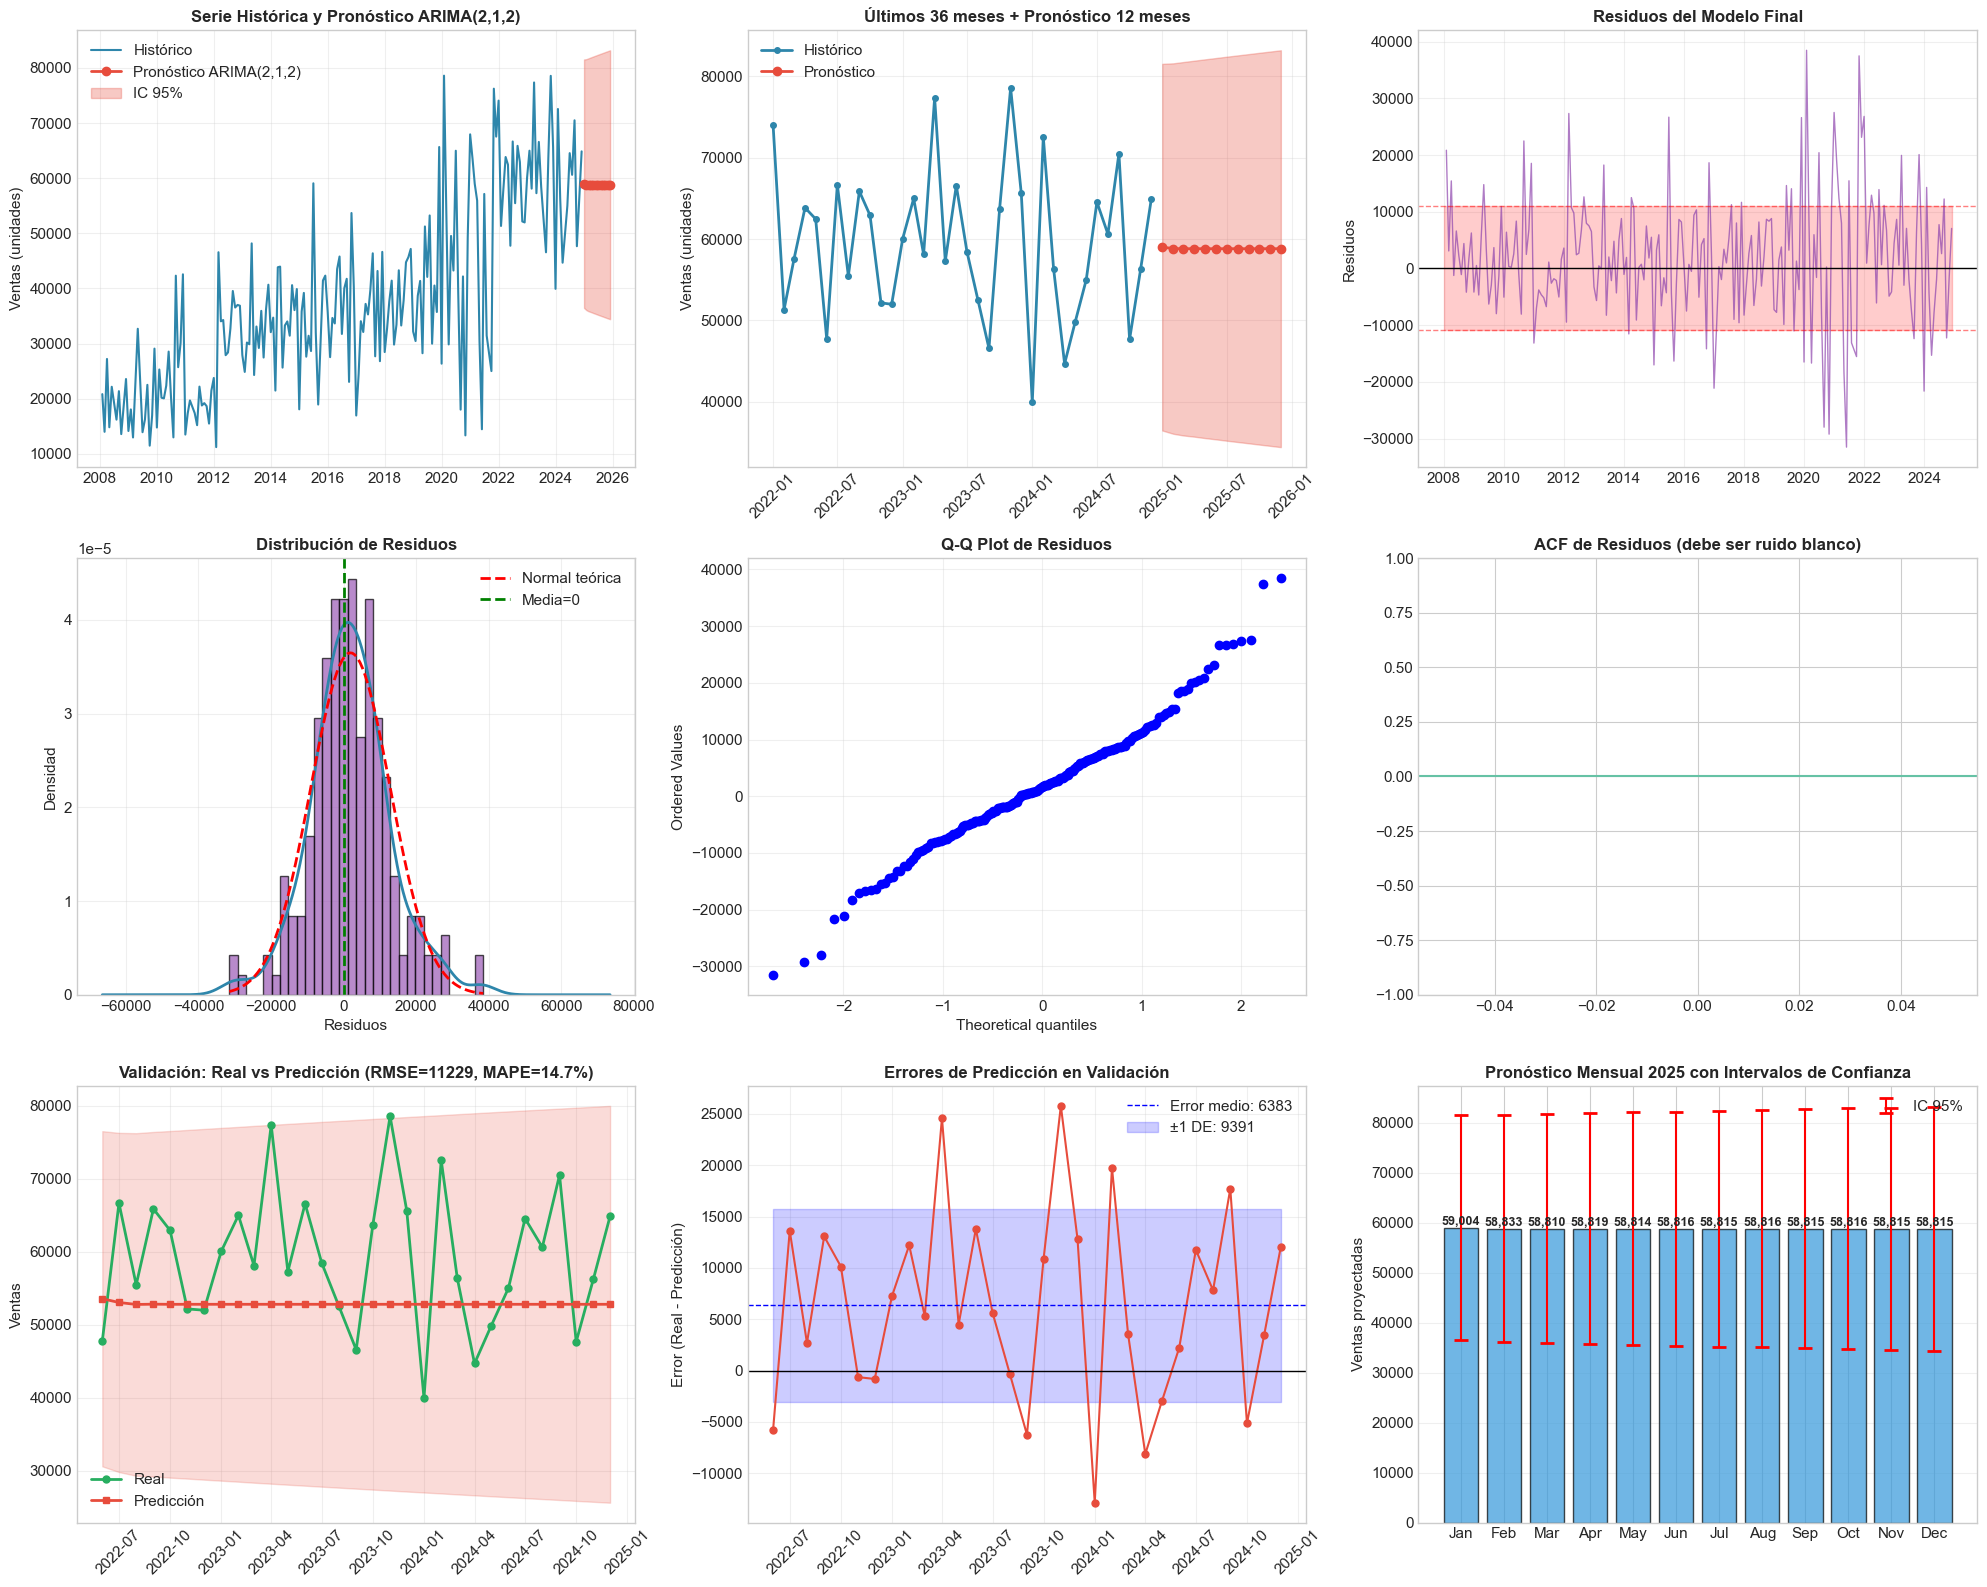


✓ Visualizaciones guardadas en: /Users/DELL/datasets\arima_final_implementacion.png

✓ Resultados exportados:
   • /Users/DELL/datasets\pronostico_arima_2025.csv
   • /Users/DELL/datasets\metricas_arima_final.csv
   • /Users/DELL/datasets\serie_ajustada_arima.csv

IMPLEMENTACIÓN ARIMA COMPLETADA ✓

💡 RECOMENDACIONES:
   1. Si MAPE > 20%, considerar modelo SARIMA para capturar estacionalidad
   2. Si residuos no son ruido blanco, revisar especificación del modelo
   3. Monitorear pronóstico mensualmente y reajustar modelo con datos nuevos
   4. Considerar variables exógenas si hay factores externos identificables


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Librerías ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (20, 14)

# ==========================================
# 1. CARGAR SERIE LIMPIA (del Box-Jenkins)
# ==========================================

mainpath = "/Users/DELL/datasets"

print("="*80)
print("MODELO ARIMA FINAL - IMPLEMENTACIÓN Y PRONÓSTICO")
print("="*80)

# Intentar cargar serie limpia, si no existe, crearla
try:
    ts_limpia = pd.read_csv(os.path.join(mainpath, 'serie_limpia_sin_outliers.csv'))
    ts_limpia['FECHA'] = pd.to_datetime(ts_limpia['FECHA'])
    ts_limpia.set_index('FECHA', inplace=True)
    print("\n✓ Serie limpia cargada desde archivo previo")
except:
    print("\n⚠️  Creando serie limpia (sin outliers)...")
    filename = "VEN.csv"
    FILE = os.path.join(mainpath, filename)
    
    df = pd.read_csv(FILE)
    df['FECHA'] = pd.to_datetime(df['AÑO'].astype(str) + '-' + df['MES'].astype(str) + '-01')
    df_ventas = df[df['CONCEPTO'] == 'FACTURA VTA'].copy()
    
    serie_mensual = df_ventas.groupby('FECHA')['UNIDADES'].sum().sort_index()
    date_range = pd.date_range(start=serie_mensual.index.min(), end=serie_mensual.index.max(), freq='MS')
    ts_df = pd.DataFrame({'VENTAS': serie_mensual}).reindex(date_range, fill_value=0)
    ts_df['VENTAS'] = ts_df['VENTAS'].replace(0, np.nan).interpolate(method='linear')
    
    # Eliminar outliers
    n_outliers = 5
    outliers_altos = ts_df.nlargest(n_outliers, 'VENTAS')
    outliers_bajos = ts_df.nsmallest(n_outliers, 'VENTAS')
    outliers_indices = outliers_altos.index.union(outliers_bajos.index)
    
    ts_limpia = ts_df.copy()
    ts_limpia.loc[outliers_indices, 'VENTAS'] = np.nan
    ts_limpia['VENTAS'] = ts_limpia['VENTAS'].interpolate(method='linear')
    
    ts_limpia.to_csv(os.path.join(mainpath, 'serie_limpia_sin_outliers.csv'))

print(f"\n📊 DATOS:")
print(f"   Periodo: {ts_limpia.index.min().strftime('%Y-%m')} a {ts_limpia.index.max().strftime('%Y-%m')}")
print(f"   Total observaciones: {len(ts_limpia)}")
print(f"   Media: {ts_limpia['VENTAS'].mean():.2f}")
print(f"   Desv. Std: {ts_limpia['VENTAS'].std():.2f}")

# ==========================================
# 2. ESPECIFICAR MODELO ARIMA ÓPTIMO
# ==========================================

print("\n" + "="*80)
print("CONFIGURACIÓN DEL MODELO ARIMA")
print("="*80)

# AQUÍ SE ESPECIFICA EL MODELO ENCONTRADO EN BOX-JENKINS
# Modifica estos valores según tu resultado de Box-Jenkins
# Ejemplo: Si Box-Jenkins encontró ARIMA(2,1,2), usa:
p = 2  # Orden AR (del PACF)
d = 1  # Orden de diferenciación (para hacer la serie estacionaria)
q = 2  # Orden MA (del ACF)

# Para modelo estacional SARIMA, agrega:
# P, D, Q, s = 1, 1, 1, 12  # Componente estacional

print(f"\n📊 MODELO SELECCIONADO: ARIMA({p},{d},{q})")
print(f"\n   Parámetros:")
print(f"   • p (AR): {p} - Orden autorregresivo")
print(f"   • d (I): {d} - Orden de diferenciación")
print(f"   • q (MA): {q} - Orden de media móvil")

# Verificar estacionariedad
serie_original = ts_limpia['VENTAS']
adf_test = adfuller(serie_original.dropna(), autolag='AIC')
print(f"\n📈 Test ADF en serie original:")
print(f"   p-value: {adf_test[1]:.6f}")
print(f"   {'✓ Estacionaria' if adf_test[1] < 0.05 else '✗ No estacionaria (requiere diferenciación)'}")

if d > 0:
    serie_diff = serie_original.diff(d).dropna()
    adf_test_diff = adfuller(serie_diff, autolag='AIC')
    print(f"\n📈 Test ADF después de {d} diferencia(s):")
    print(f"   p-value: {adf_test_diff[1]:.6f}")
    print(f"   {'✓ Ahora es estacionaria' if adf_test_diff[1] < 0.05 else '⚠️ Considerar más diferenciación'}")

# ==========================================
# 3. AJUSTE DEL MODELO CON DATOS COMPLETOS
# ==========================================

print("\n" + "="*80)
print("AJUSTE DEL MODELO ARIMA")
print("="*80)

# Dividir en train/test para validación
train_size = int(len(ts_limpia) * 0.85)
train_data = ts_limpia['VENTAS'][:train_size]
test_data = ts_limpia['VENTAS'][train_size:]

print(f"\n📊 División de datos:")
print(f"   Entrenamiento: {len(train_data)} obs ({train_data.index[0].strftime('%Y-%m')} a {train_data.index[-1].strftime('%Y-%m')})")
print(f"   Validación: {len(test_data)} obs ({test_data.index[0].strftime('%Y-%m')} a {test_data.index[-1].strftime('%Y-%m')})")

# Ajustar modelo con datos de entrenamiento
print(f"\n🔄 Ajustando modelo ARIMA({p},{d},{q})...")
try:
    model_train = ARIMA(train_data, order=(p, d, q))
    fitted_model_train = model_train.fit()
    print("✓ Modelo ajustado exitosamente")
except Exception as e:
    print(f"✗ Error al ajustar modelo: {e}")
    # Intentar con modelo más simple
    print("\n⚠️ Intentando con modelo ARIMA(1,1,1)...")
    p, d, q = 1, 1, 1
    model_train = ARIMA(train_data, order=(p, d, q))
    fitted_model_train = model_train.fit()
    print("✓ Modelo alternativo ajustado")

print("\n" + "="*80)
print("RESUMEN DEL MODELO")
print("="*80)
print(fitted_model_train.summary())

# ==========================================
# 4. DIAGNÓSTICO DE RESIDUOS
# ==========================================

print("\n" + "="*80)
print("DIAGNÓSTICO DE RESIDUOS")
print("="*80)

residuos = fitted_model_train.resid

# Estadísticas básicas
print(f"\n📊 Estadísticas de residuos:")
print(f"   Media: {residuos.mean():.6f} (óptimo: ~0)")
print(f"   Desv. Std: {residuos.std():.2f}")
print(f"   Varianza: {residuos.var():.2f}")
print(f"   Asimetría: {residuos.skew():.4f} (óptimo: ~0)")
print(f"   Curtosis: {residuos.kurtosis():.4f} (óptimo: ~0)")
print(f"   Min: {residuos.min():.2f}")
print(f"   Max: {residuos.max():.2f}")

# Prueba de normalidad
_, p_shapiro = stats.shapiro(residuos)
print(f"\n📈 Test Shapiro-Wilk (normalidad de residuos):")
print(f"   Estadístico W: {_:.4f}")
print(f"   p-value: {p_shapiro:.6f}")
if p_shapiro > 0.05:
    print(f"   ✓ Los residuos siguen distribución normal (α=0.05)")
else:
    print(f"   ⚠️ Los residuos NO siguen distribución normal (puede afectar intervalos de confianza)")

# Prueba Ljung-Box (autocorrelación)
lb_test = acorr_ljungbox(residuos, lags=[10, 20], return_df=True)
print(f"\n📈 Test Ljung-Box (autocorrelación de residuos):")
print(lb_test)
if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print(f"   ✓ Los residuos NO están autocorrelacionados (ruido blanco)")
else:
    print(f"   ⚠️ Los residuos muestran autocorrelación (modelo puede mejorarse)")

# Test de heterocedasticidad
from scipy.stats import levene
mid = len(residuos) // 2
_, p_levene = levene(residuos[:mid], residuos[mid:])
print(f"\n📈 Test de Levene (homocedasticidad):")
print(f"   p-value: {p_levene:.6f}")
if p_levene > 0.05:
    print(f"   ✓ Varianza constante en residuos")
else:
    print(f"   ⚠️ Posible heterocedasticidad")

# ==========================================
# 5. EVALUACIÓN EN CONJUNTO DE VALIDACIÓN
# ==========================================

print("\n" + "="*80)
print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
print("="*80)

# Predicción en test set
forecast_test = fitted_model_train.forecast(steps=len(test_data))
forecast_conf = fitted_model_train.get_forecast(steps=len(test_data)).conf_int()

# Métricas de desempeño
rmse = np.sqrt(mean_squared_error(test_data, forecast_test))
mae = mean_absolute_error(test_data, forecast_test)
mape = mean_absolute_percentage_error(test_data, forecast_test) * 100

# Calcular R²
ss_res = np.sum((test_data - forecast_test)**2)
ss_tot = np.sum((test_data - test_data.mean())**2)
r2 = 1 - (ss_res / ss_tot)

print(f"\n📊 MÉTRICAS DE DESEMPEÑO:")
print(f"   RMSE (Root Mean Squared Error): {rmse:.2f} unidades")
print(f"   MAE (Mean Absolute Error): {mae:.2f} unidades")
print(f"   MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"   R² (Coeficiente de determinación): {r2:.4f}")

# Benchmark: modelo naive
naive_forecast = [train_data.iloc[-1]] * len(test_data)
rmse_naive = np.sqrt(mean_squared_error(test_data, naive_forecast))
mae_naive = mean_absolute_error(test_data, naive_forecast)

print(f"\n📊 COMPARACIÓN CON MODELO NAIVE:")
print(f"   RMSE Naive: {rmse_naive:.2f}")
print(f"   MAE Naive: {mae_naive:.2f}")
print(f"   Mejora RMSE: {((rmse_naive - rmse)/rmse_naive)*100:.2f}%")
print(f"   Mejora MAE: {((mae_naive - mae)/mae_naive)*100:.2f}%")

# Interpretación
if mape < 10:
    interpretacion = "Excelente"
elif mape < 20:
    interpretacion = "Bueno"
elif mape < 30:
    interpretacion = "Aceptable"
else:
    interpretacion = "Necesita mejora"

print(f"\n💡 INTERPRETACIÓN: Desempeño {interpretacion} (MAPE={mape:.2f}%)")

# ==========================================
# 6. MODELO FINAL CON TODOS LOS DATOS
# ==========================================

print("\n" + "="*80)
print("MODELO FINAL (CON TODOS LOS DATOS)")
print("="*80)

# Reajustar con TODA la data limpia
print(f"\n🔄 Reajustando modelo con {len(ts_limpia)} observaciones...")
model_final = ARIMA(ts_limpia['VENTAS'], order=(p, d, q))
fitted_model_final = model_final.fit()
print("✓ Modelo final ajustado")

print(f"\n📊 INFORMACIÓN DEL MODELO FINAL:")
print(f"   AIC: {fitted_model_final.aic:.2f}")
print(f"   BIC: {fitted_model_final.bic:.2f}")
print(f"   HQIC: {fitted_model_final.hqic:.2f}")
print(f"   Log-Likelihood: {fitted_model_final.llf:.2f}")

# ==========================================
# 7. PRONÓSTICO FUTURO
# ==========================================

print("\n" + "="*80)
print("PRONÓSTICO FUTURO (12 MESES)")
print("="*80)

# Generar pronóstico para los próximos 12 meses
n_periodos = 12
forecast_future = fitted_model_final.forecast(steps=n_periodos)
forecast_future_conf = fitted_model_final.get_forecast(steps=n_periodos)
forecast_conf_int = forecast_future_conf.conf_int()

# Crear fechas futuras
ultima_fecha = ts_limpia.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha + pd.DateOffset(months=1), 
                                periods=n_periodos, freq='MS')

# Crear DataFrame de pronóstico
df_pronostico = pd.DataFrame({
    'FECHA': fechas_futuras,
    'PRONOSTICO': forecast_future.values,
    'LIMITE_INFERIOR_95': forecast_conf_int.iloc[:, 0].values,
    'LIMITE_SUPERIOR_95': forecast_conf_int.iloc[:, 1].values
})

df_pronostico['AMPLITUD_IC'] = df_pronostico['LIMITE_SUPERIOR_95'] - df_pronostico['LIMITE_INFERIOR_95']

print(f"\n📈 PRONÓSTICO 2025:")
print(f"\n{'Fecha':<12} {'Pronóstico':>12} {'IC 95% Inferior':>16} {'IC 95% Superior':>16} {'Amplitud IC':>12}")
print("-" * 80)
for _, row in df_pronostico.iterrows():
    print(f"{row['FECHA'].strftime('%Y-%m'):<12} {row['PRONOSTICO']:>12,.0f} "
          f"{row['LIMITE_INFERIOR_95']:>16,.0f} {row['LIMITE_SUPERIOR_95']:>16,.0f} "
          f"{row['AMPLITUD_IC']:>12,.0f}")

# Estadísticas del pronóstico
print(f"\n📊 ESTADÍSTICAS DEL PRONÓSTICO:")
print(f"   Promedio mensual proyectado: {df_pronostico['PRONOSTICO'].mean():,.0f} unidades")
print(f"   Total anual proyectado: {df_pronostico['PRONOSTICO'].sum():,.0f} unidades")
print(f"   Crecimiento vs último año histórico: {((df_pronostico['PRONOSTICO'].sum() / ts_limpia['VENTAS'][-12:].sum())-1)*100:+.2f}%")
print(f"   Amplitud promedio IC: {df_pronostico['AMPLITUD_IC'].mean():,.0f} unidades")

# ==========================================
# 8. VISUALIZACIONES
# ==========================================

fig = plt.figure(figsize=(20, 16))

# 8.1 Serie completa con pronóstico
ax1 = plt.subplot(3, 3, 1)
ax1.plot(ts_limpia.index, ts_limpia['VENTAS'], linewidth=1.5, color='#2E86AB', label='Histórico')
ax1.plot(fechas_futuras, df_pronostico['PRONOSTICO'], linewidth=2, color='#E74C3C', 
         marker='o', markersize=6, label=f'Pronóstico ARIMA({p},{d},{q})')
ax1.fill_between(fechas_futuras, 
                  df_pronostico['LIMITE_INFERIOR_95'], 
                  df_pronostico['LIMITE_SUPERIOR_95'],
                  alpha=0.3, color='#E74C3C', label='IC 95%')
ax1.set_title(f'Serie Histórica y Pronóstico ARIMA({p},{d},{q})', fontweight='bold', fontsize=12)
ax1.set_ylabel('Ventas (unidades)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 8.2 Últimos 36 meses + pronóstico
ax2 = plt.subplot(3, 3, 2)
ultimos_meses = 36
ax2.plot(ts_limpia.index[-ultimos_meses:], ts_limpia['VENTAS'][-ultimos_meses:], 
         linewidth=2, color='#2E86AB', marker='o', markersize=4, label='Histórico')
ax2.plot(fechas_futuras, df_pronostico['PRONOSTICO'], linewidth=2, color='#E74C3C', 
         marker='o', markersize=6, label='Pronóstico')
ax2.fill_between(fechas_futuras, 
                  df_pronostico['LIMITE_INFERIOR_95'], 
                  df_pronostico['LIMITE_SUPERIOR_95'],
                  alpha=0.3, color='#E74C3C')
ax2.set_title(f'Últimos {ultimos_meses} meses + Pronóstico 12 meses', fontweight='bold', fontsize=12)
ax2.set_ylabel('Ventas (unidades)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 8.3 Residuos del modelo
ax3 = plt.subplot(3, 3, 3)
residuos_final = fitted_model_final.resid
ax3.plot(residuos_final.index, residuos_final, linewidth=1, color='#8E44AD', alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.axhline(y=residuos_final.std(), color='red', linestyle='--', linewidth=1, alpha=0.5)
ax3.axhline(y=-residuos_final.std(), color='red', linestyle='--', linewidth=1, alpha=0.5)
ax3.fill_between(residuos_final.index, -residuos_final.std(), residuos_final.std(), 
                  alpha=0.2, color='red')
ax3.set_title('Residuos del Modelo Final', fontweight='bold', fontsize=12)
ax3.set_ylabel('Residuos')
ax3.grid(True, alpha=0.3)

# 8.4 Distribución de residuos
ax4 = plt.subplot(3, 3, 4)
ax4.hist(residuos_final, bins=30, density=True, alpha=0.7, color='#9B59B6', edgecolor='black')
residuos_final.plot(kind='kde', ax=ax4, color='#2E86AB', linewidth=2)
mu, sigma = residuos_final.mean(), residuos_final.std()
x = np.linspace(residuos_final.min(), residuos_final.max(), 100)
ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'r--', linewidth=2, label='Normal teórica')
ax4.axvline(0, color='green', linestyle='--', linewidth=2, label='Media=0')
ax4.set_title('Distribución de Residuos', fontweight='bold', fontsize=12)
ax4.set_xlabel('Residuos')
ax4.set_ylabel('Densidad')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 8.5 Q-Q Plot
ax5 = plt.subplot(3, 3, 5)
stats.probplot(residuos_final, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot de Residuos', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

# 8.6 ACF de residuos
ax6 = plt.subplot(3, 3, 6)
plot_acf(residuos_final, lags=24, ax=ax6, alpha=0.05)
ax6.set_title('ACF de Residuos (debe ser ruido blanco)', fontweight='bold', fontsize=12)

# 8.7 Valores ajustados vs reales (validación)
ax7 = plt.subplot(3, 3, 7)
ax7.plot(test_data.index, test_data, linewidth=2, color='#27AE60', 
         marker='o', markersize=5, label='Real')
ax7.plot(test_data.index, forecast_test, linewidth=2, color='#E74C3C', 
         marker='s', markersize=5, label='Predicción')
ax7.fill_between(test_data.index, 
                  forecast_conf.iloc[:, 0], 
                  forecast_conf.iloc[:, 1],
                  alpha=0.2, color='#E74C3C')
ax7.set_title(f'Validación: Real vs Predicción (RMSE={rmse:.0f}, MAPE={mape:.1f}%)', 
              fontweight='bold', fontsize=12)
ax7.set_ylabel('Ventas')
ax7.legend()
ax7.grid(True, alpha=0.3)
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45)

# 8.8 Errores de predicción en validación
ax8 = plt.subplot(3, 3, 8)
errores = test_data - forecast_test
ax8.plot(test_data.index, errores, linewidth=1.5, color='#E74C3C', marker='o', markersize=5)
ax8.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax8.axhline(y=errores.mean(), color='blue', linestyle='--', linewidth=1, 
            label=f'Error medio: {errores.mean():.0f}')
ax8.fill_between(test_data.index, 
                  errores.mean() - errores.std(), 
                  errores.mean() + errores.std(),
                  alpha=0.2, color='blue', label=f'±1 DE: {errores.std():.0f}')
ax8.set_title('Errores de Predicción en Validación', fontweight='bold', fontsize=12)
ax8.set_ylabel('Error (Real - Predicción)')
ax8.legend()
ax8.grid(True, alpha=0.3)
plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45)

# 8.9 Pronóstico mensual con barras
ax9 = plt.subplot(3, 3, 9)
meses_nombres = [fecha.strftime('%b') for fecha in fechas_futuras]
bars = ax9.bar(range(len(meses_nombres)), df_pronostico['PRONOSTICO'], 
               color='#3498DB', alpha=0.7, edgecolor='black')
ax9.errorbar(range(len(meses_nombres)), df_pronostico['PRONOSTICO'],
             yerr=[df_pronostico['PRONOSTICO'] - df_pronostico['LIMITE_INFERIOR_95'],
                   df_pronostico['LIMITE_SUPERIOR_95'] - df_pronostico['PRONOSTICO']],
             fmt='none', color='red', capsize=5, capthick=2, label='IC 95%')
ax9.set_xticks(range(len(meses_nombres)))
ax9.set_xticklabels(meses_nombres)
ax9.set_title('Pronóstico Mensual 2025 con Intervalos de Confianza', fontweight='bold', fontsize=12)
ax9.set_ylabel('Ventas proyectadas')
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

# Agregar valores sobre barras
for i, (bar, val) in enumerate(zip(bars, df_pronostico['PRONOSTICO'])):
    ax9.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{int(val):,}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
output_file = os.path.join(mainpath, 'arima_final_implementacion.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualizaciones guardadas en: {output_file}")

# ==========================================
# 9. EXPORTAR RESULTADOS
# ==========================================

# Pronóstico
df_pronostico.to_csv(os.path.join(mainpath, 'pronostico_arima_2025.csv'), index=False)

# Métricas
metricas_finales = pd.DataFrame({
    'Modelo': [f'ARIMA({p},{d},{q})'],
    'AIC': [fitted_model_final.aic],
    'BIC': [fitted_model_final.bic],
    'RMSE_Validacion': [rmse],
    'MAE_Validacion': [mae],
    'MAPE_Validacion': [mape],
    'R2_Validacion': [r2],
    'Observaciones_Train': [len(train_data)],
    'Observaciones_Test': [len(test_data)]
})
metricas_finales.to_csv(os.path.join(mainpath, 'metricas_arima_final.csv'), index=False)

# Serie con valores ajustados
fitted_values = fitted_model_final.fittedvalues
df_ajustado = pd.DataFrame({
    'FECHA': ts_limpia.index,
    'VENTAS_REAL': ts_limpia['VENTAS'].values,
    'VENTAS_AJUSTADA': fitted_values.values,
    'RESIDUO': residuos_final.values
})
df_ajustado.to_csv(os.path.join(mainpath, 'serie_ajustada_arima.csv'), index=False)

print(f"\n✓ Resultados exportados:")
print(f"   • {os.path.join(mainpath, 'pronostico_arima_2025.csv')}")
print(f"   • {os.path.join(mainpath, 'metricas_arima_final.csv')}")
print(f"   • {os.path.join(mainpath, 'serie_ajustada_arima.csv')}")

print("\n" + "="*80)
print("IMPLEMENTACIÓN ARIMA COMPLETADA ✓")
print("="*80)

print("\n💡 RECOMENDACIONES:")
print("   1. Si MAPE > 20%, considerar modelo SARIMA para capturar estacionalidad")
print("   2. Si residuos no son ruido blanco, revisar especificación del modelo")
print("   3. Monitorear pronóstico mensualmente y reajustar modelo con datos nuevos")
print("   4. Considerar variables exógenas si hay factores externos identificables")